# Import libraries

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import unicodedata
import re
import json

from pathlib import Path
import zipfile

# h3 - uber
import h3

# Define variables

## cwd

In [3]:
cwd = Path.cwd()
print("Current working directory:", cwd)

Current working directory: /Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project


## Mappings

In [4]:
## Mapping
homologated_mapping = {
    # Casas
    "Casa": "Casa",
    "Casa en condominio": "Casa en Condominio",
    "Casa en Fraccionamiento": "Casa en Condominio",
    "Condominio Horizontal": "Casa en Condominio",
    "Desarrollo-Casa": "Casa",
    "Desarrollo-Casa en condominio": "Casa en Condominio",
    "Casa - Comercial": "Casa Comercial",
    # Departamentos
    "Departamento": "Departamento",
    "Penthouse": "Departamento",
    "Loft": "Departamento",
    "Estudio": "Departamento",
    "Dúplex": "Dúplex",
    "Desarrollo-Duplex": "Dúplex",
    "Desarrollo-Apartamento": "Departamento",
    # Terrenos
    "Lote / Terreno": "Terreno",
    "Terreno": "Terreno",
    "Desarrollo-Terreno": "Terreno",
    "Terreno habitacional": "Terreno",
    "Terreno - Comercial": "Terreno Comercial",
    "Terreno comercial": "Terreno Comercial",
    "Terreno - Industrial": "Terreno Industrial",
    "Terreno industrial": "Terreno Industrial",
    # Comerciales y Oficinas
    "Tienda / Local Comercial": "Local Comercial",
    "Local - Comercial": "Local Comercial",
    "Local": "Local Comercial",
    "Lote Comercial": "Terreno Comercial",
    "Local en Centro Comercial": "Centro Comercial",
    "Desarrollo-Local Comercial": "Local Comercial",
    "Desarrollo-Local en centro comercial": "Centro Comercial",
    "Plaza - Comercial": "Centro Comercial",
    "Centro - Comercial": "Centro Comercial",
    "Oficina": "Oficina",
    "Oficina - Comercial": "Oficina",
    "Desarrollo-Oficina comercial": "Oficina",
    "Consultorio Médico": "Consultorio",
    "Consultorio - Comercial": "Consultorio",
    "Hospital - Comercial": "Hospital",
    # Bodegas y Naves Industriales
    "Nave Industrial / Bodega": "Bodega",
    "Bodega - Comercial": "Bodega",
    "Bodega comercial": "Bodega",
    "Bodega - Industrial": "Bodega Industrial",
    "Nave - Industrial": "Bodega Industrial",
    "Parque - Industrial": "Parque Industrial",
    "Fábrica - Industrial": "Fábrica Industrial",
    # Edificios
    "Edificio": "Edificio",
    "Edificio - Comercial": "Edificio Comercial",
    "Desarrollo-Edificio": "Edificio",
    # Hoteles y Entretenimiento
    "Entretenimiento / Hotel": "Hotel",
    "Hotel - Comercial": "Hotel",
    # Villas y Quintas
    "Quinta": "Quinta",
    "Rancho": "Rancho",
    "Quinta / Hacienda": "Quinta",
    "Rancho / Huerta": "Rancho",
    "Finca/Rancho": "Rancho",
    "Finca/Rancho - Comercial": "Rancho Comercial",
    "Desarrollo-Villa": "Villa",
    "Villa": "Villa",
    # Misceláneos
    "Desarrollo": "Desarrollo",
    "Cuarto": "Cuarto",
}

ordered_columns = [
    "id",
    "id_ext",
    "id_dev",
    "title",
    "description",
    "approximate_address",
    "street_name",
    "ext_number",
    "int_number",
    "neighborhood",
    "del_mun",
    "city",
    "city_area",
    "region",
    "state",
    "country",
    "zip_code",
    "lat",
    "lon",
    "property_type",
    "property_type_raw",
    "operation_type",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "year_built",
    "asking_price",
    "currency",
    "maintenance_fee",  # "asking_price_pesos",
    "m2_built",
    "m2_terrain",
    "m2_balconies",
    "m2_terraces",
    "m2_rooftop",
    "amenidades",
    "jacuzzi",
    "alberca",
    "gimnasio",
    "salonusosmultiples",
    "elevador",
    "asador",
    "publisher_name",
    "publisher_type",
    "source_type",  # "source",
    "source_listing_url",
    "main_development_url",
    "publication_date",
    "date_scraped",
    # "potential_duplicates", "num_pot_duplicates",
    "is_development",
    "is_remate",
]

common_columns = [
    "id",
    "title",
    "amenidades",
    "approximate_address",
    "apt_floor",
    "asking_price",
    "city",
    "city_area",
    "content",
    "country",
    "currency",
    "date_scraped",
    "del_mun",
    "ext_number",
    "int_number",
    "lat",
    "lon",
    "m2_balconies",
    "m2_built",
    "m2_rooftop",
    "m2_terraces",
    "m2_terrain",
    "main_development_url",
    "maintenance_fee",
    "neighborhood",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "operation_type",
    "phone_number",
    "property_type",
    "publication_date",
    "publisher_name",
    "publisher_type",
    "region",
    "source_listing_url",
    "source_type",
    "state",
    "street_name",
    "year_built",
    "zip_code",
]

tracked_fields = [
    "asking_price",
    "currency",
    "m2_built",
    "m2_terrain",
    "lat",
    "lon",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "year_built",
]

## Create helper functions

In [5]:
def find_git_root(start: Path | None = None) -> Path:
    current = start or Path.cwd()

    for parent in [current, *current.parents]:
        if (parent / ".git").exists():
            return parent

    raise RuntimeError("Git root not found")

In [6]:
def _clean_text_expr(col: str) -> pl.Expr:
    # Use Unicode property + joiners; replace with " " (space), not ""
    EMOJI_RE = r"(?:\p{Extended_Pictographic}|\uFE0F|\u200D|\u20E3)"

    return (
        pl.col(col)
        .cast(pl.Utf8, strict=False)
        .fill_null("")
        .str.replace_all(
            EMOJI_RE, " "
        )  # changes for a space, due to same words getting fusioned (preventapreventa)
        .str.normalize("NFKD")
        .str.replace_all(r"\p{M}+", "")
        .str.to_uppercase()
        .str.replace_all(r"\s+", " ")
        .str.strip_chars()
    )


In [7]:
def extract_development_id(col: str) -> pl.Expr:
    url = pl.col(col).cast(pl.Utf8, strict=False)

    return (
        pl.when(url.is_not_null())  # simulates `isinstance(url, str)`
        # If it a string, then extract desarrollo id base on regex expression
        .then(
            pl.when(url.str.contains(r"inmuebles24\.com"))
            .then(url.str.extract(r"desarrollo/([^/]+)-\d+\.html", group_index=1))
            .otherwise(
                pl.when(url.str.contains(r"lamudi\.com\.mx"))
                .then(url.str.extract(r"desarrollo/([a-zA-Z0-9\-]+)$", group_index=1))
                .otherwise(pl.lit(None, dtype=pl.Utf8))
            )
        )
        # If is not string, returns None
        .otherwise(pl.lit(None, dtype=pl.Utf8))
    )


In [8]:
def is_remate(col: str) -> pl.Expr:
    # literal=False -> interpret pattern as regex
    """
    Returns boolean or null for the regex expression.
    Then it fills the nulls into False with fill_null.
    POlars use three-valued logic
    """
    
    # Filter out "remates" but keep "preventa"
    str_filter_remates = (
        r"REMATE|REMATO|PRECIO INMEJORABLE|ATENCION INVERSIONISTA|BAJO CONTRATO|BAJO COSTO|CONTADO|"
        r"COSTO COMERCIAL|COSTO LIQUIDACION|COSTO TOTAL|DE AHORRO|HIPOTECARIA|LIQUIDACION|NO CRED|NO SE ACEPTAN CR|"
        r"NOTARIADO|POR DEBAJO|PRECIO DEBAJO|PRIMER PAGO|RECUPERACION|REMAT|SOLO EFECTIVO|STATUS JURIDICO|TRAMITE|"
        r"UNICA OPORTUNIDAD|INIGUALABLE|OPORTUNIDAD DE INVERS|OPORTUNIDAD DE ADQUIRIR|VALOR AVALUO|VALOR COMERCIAL|"
        r"RECURSOS PROP|SENTENCIA|INVALIDO|JUICIO|ADJUDICA|DESCUENT|RENTA|MITAD DE PRECIO|MITAD-DE-PRECIO|REBAJ|"
        r"PRECIO-ABAJO-DEL|POR DEBAJO DE|POR-DEBAJO|VALOR-CATASTRAL|AL COSTO|AL-COSTO|BAJO DE SU COSTO|% DE SU VALOR COMERCIAL|"
        r"SOBRE SU VALOR COMERCIAL|NO-CRED"
    )
    str_filter_preventa = r"PREVENTA|PRE VENTA|PRE-VENTA|LANZAMIENTO"

    text = pl.col(col).cast(pl.Utf8)
    has_remate = text.str.contains(str_filter_remates, literal=False).fill_null(False)
    has_preventa = text.str.contains(str_filter_preventa, literal=False).fill_null(False)
    is_remate = pl.when(text.is_not_null()).then(has_remate & ~has_preventa).otherwise(False)
    return is_remate

In [9]:
def clean_dict_keys(d):
    if not isinstance(d, dict):
        return {}

    cleaned_dict = {}
    for key, value in d.items():
        clean_key = (
            unicodedata.normalize("NFKD", key)
            .encode("ascii", "ignore")
            .decode("utf-8")
        )
        clean_key = (
            re.sub(r"[^a-zA-Z0-9\s]", "", clean_key)
            .lower()
            .replace(" ", "_")
        )
        cleaned_dict[clean_key] = value

    return cleaned_dict


# 2) tiny normalizer: JSON string -> normalized JSON string (same semantics as pandas)
## Function similar to pandas code
### all_sources['amenidades'] = all_sources['amenidades'].apply(
###     lambda x: clean_dict_keys(json.loads(x))
###     if isinstance(x, str) and x.startswith('{') else {}
### )
### lstrip removes leading spaces characters

def _normalize_amenidades_json(string: str) -> str:
    if isinstance(string, str) and string.lstrip().startswith("{"):
        try:
            d = json.loads(string)
            d = clean_dict_keys(d)  # identical normalization to pandas

            def v2s(v):
                if v is None:
                    return ""
                if isinstance(v, bool):
                    return "true" if v else "false"
                if isinstance(v, (int, float)):
                    return (
                        str(int(v))
                        if isinstance(v, float) and v.is_integer()
                        else str(v)
                    )
                return str(v)

            return json.dumps(
                {k: v2s(v) for k, v in d.items()},
                ensure_ascii=False,
            )
        except Exception:
            return "{}"

    return "{}"


In [10]:
def amen_bool(k: str) -> pl.Expr:
    _truthy = {"1", "true", "t", "yes", "y", "si", "sí"}
    _falsey = {"0", "false", "f", "no", "n"}
    
    raw = pl.col("amen_raw").struct.field(k)
    s = (
        raw.cast(pl.Utf8, strict=False)
        .str.strip_chars()
        .str.strip_chars('"')
        .str.to_lowercase()
    )
    # num = s.cast(pl.Float64, strict=True) # strict=True raises error
    # Extracts integer/decimal (with . or ,), normalizes to ".", and converts to float
    num = s.str.extract(r"(-?\d+(?:[.,]\d+)?)").str.replace(",", ".").cast(pl.Float64)

    return (
        pl.when(raw.is_null())
        .then(None)  # missing key
        .when(num.is_not_null())
        .then(num > 0)  # Verify position: here or below? "4"/"4.0"/"-1" -> True, "0" -> False
        .when(s == "")
        .then(None)  # empty string -> NULL
        .when(s.is_in(list(_truthy)))
        .then(pl.lit(True))  # textual truthy
        .when(s.is_in(list(_falsey)))
        .then(pl.lit(False))  # textual falsey
        .otherwise(None)
    ).alias(k)


## New cleaning function

In [11]:
def clean_data(df: pl.DataFrame) -> pl.DataFrame:

    if "content" in df.columns:
        df = df.rename({"content": "description"})


    # Homologate property type to the mapping defined
    if "property_type" in df.columns:
        df = df.with_columns(
            pl.coalesce(
                [
                    pl.col("property_type").replace(homologated_mapping),  # case-sensitive
                    pl.col("property_type"),
                ]
            )
            .str.to_uppercase()
            .alias("property_type_homo")
        )
    else:
        df = df.with_columns(
            pl.lit(None, dtype=pl.Utf8).alias("property_type_homo")
            )

    # Ensure string columns used later exist
    ## If they don't exist, mark as None
    ## Then update the schema (missing columns are present know)
    need_utf8 = [
        "property_type",
        "description",
        "main_development_url",
        "title",
        "source_listing_url",
        "amenidades",
        "publisher_name",
    ]
    missing = [column for column in need_utf8 if column not in df.columns]
    if missing:
        df = df.with_columns([pl.lit(None, dtype=pl.Utf8).alias(column) for column in missing])

    # Clean text columns
    ## (?i) == case=False
    ## fill.null(False) == na=false
    preventa_re = r"(?i)\bpreventa(?:s)?\b|\bpre venta(?:s)?\b|\bpre-venta(?:s)?\b"

    df = df.with_columns(
        [
            _clean_text_expr("title").alias("title_clean"),
            _clean_text_expr("description").alias("description_clean"),
            _clean_text_expr("property_type").alias("property_type_clean"),
            _clean_text_expr("source_listing_url").alias("source_listing_url_clean"),
        ]
    )

    # Identify developments
    df = df.with_columns(
        (
            pl.col("property_type_clean")
            .cast(pl.Utf8)
            .str.contains(r"(?i)desarrollo", literal=False)
            .fill_null(False)
            | pl.col("description_clean")
            .cast(pl.Utf8)
            .str.contains(preventa_re, literal=False)
            .fill_null(False)
            | (pl.col("year_built").cast(pl.Float64, strict=False) >= 2025).fill_null(False)
            | pl.col("main_development_url").cast(pl.Utf8).is_not_null().fill_null(False)
        ).alias("is_development")
    )

    # Extract development id from main_development_url and creates "id_dev"
    df = df.with_columns(extract_development_id("main_development_url").alias("id_dev"))

    # Assumes `property_type_homo` already exists (from your earlier mapping step)
    terreno_re = r"(?i)\bterreno(?:s)?\b|\blote(?:s)?\b|\bmacrolote(?:s)?\b"
    casa_re = r"(?i)\bcasa(?:s)?\b"
    is_des = pl.col("property_type_homo").cast(pl.Utf8) == "DESARROLLO" # TODO ADDED corrected property type homo

    # Identifies types of desarrollo
    ## DESARROLLO & (title has terreno/lote/macrolote) -> TERRENO,  otherwise maintains property type
    df = df.with_columns(
        pl.when(
            is_des
            & pl.col("title").cast(pl.Utf8).str.contains(terreno_re, literal=False).fill_null(False)
        )
        .then(pl.lit("TERRENO"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    ## DESARROLLO & (title has casa) -> CASA, otherwise maintains property type
    df = df.with_columns(
        pl.when(
            is_des
            & pl.col("title").cast(pl.Utf8).str.contains(casa_re, literal=False).fill_null(False)
        )
        .then(pl.lit("CASA"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    ## DESARROLLO -> DEPARTAMENTO, otherwise maintains property type
    df = df.with_columns(
        pl.when(is_des)
        .then(pl.lit("DEPARTAMENTO"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    df = df.with_columns(
        (
            is_remate("description_clean")
            | is_remate("title_clean")
            | is_remate("source_listing_url_clean")
        )
        .cast(pl.Int8)
        .alias("is_remate")  # 1 or 0
    )

    # Exclude remates
    df = df.filter(pl.col("is_remate") == 0)

    # Exclude nulls lat and lon #TODO ADDED
    df = df.filter(
        pl.col("lat").is_not_null() &
        pl.col("lon").is_not_null()
    )

    # Exclude specific publishers
    if "publisher_name" in df.columns:
        df = df.filter(~pl.col("publisher_name").is_in(["Dimensión Asesores, S.A. de C.V."]))

    # Defining amenidades
    ## Normalize to JSON text (or "{}"), then decode ONLY the canonical fields as booleans
    df = df.with_columns(
        pl.when(pl.col("amenidades").is_not_null())
        .then(pl.col("amenidades").map_elements(_normalize_amenidades_json, return_dtype=pl.Utf8))
        .otherwise(pl.lit("{}"))
        .alias("amenidades_normalized")
    )

    # Decode ONLY the 6 canonical keys to a Struct of Utf8 (so empty strings remain visible)
    amen_dtype = pl.Struct(
        {
            "jacuzzi": pl.Utf8,
            "alberca": pl.Utf8,
            "gimnasio": pl.Utf8,
            "salonusosmultiples": pl.Utf8,
            "elevador": pl.Utf8,
            "asador": pl.Utf8,
        }
    )

    df = df.with_columns(
        pl.col("amenidades_normalized").str.json_decode(dtype=amen_dtype).alias("amen_raw")
    )

    # 3) Expand desired keys to columns
    df = df.with_columns(
        [
            amen_bool("jacuzzi"),
            amen_bool("alberca"),
            amen_bool("gimnasio"),
            amen_bool("salonusosmultiples"),
            amen_bool("elevador"),
            amen_bool("asador"),
        ]
    )

    # 3) Elevador rule (pandas): any non-null value not exactly False -> True; else keep (False/null)
    elevador = pl.col("elevador")
    df = df.with_columns(
        pl.when(elevador.is_not_null() & (elevador != pl.lit(False)))
        .then(pl.lit(True))
        .otherwise(elevador)
        .alias("elevador")
    )

    # 12) Final cleaning / renames
    df = df.filter(~pl.col("property_type_homo").is_in(["QUINTA", "RANCHO", "RANCHO COMERCIAL"]))
    rename_map = {}
    if "id" in df.columns:
        rename_map["id"] = "id_ext"
    if "property_type" in df.columns:
        rename_map["property_type"] = "property_type_raw"
    rename_map["property_type_homo"] = "property_type"

    df = df.rename(rename_map)

    # 13) Numeric cleaning for areas
    for metr_col in ["m2_terrain", "m2_built"]:
        if metr_col not in df.columns:
            df = df.with_columns(pl.lit(None, dtype=pl.Utf8).alias(metr_col))
    
    num_pat = r"(-?\d+(?:\.\d+)?)"
    df = df.with_columns(
        [
            pl.col("m2_terrain")
            .cast(pl.Utf8)
            .str.replace(",", "")
            .str.extract(num_pat)
            .cast(pl.Float64, strict=False)
            .alias("m2_terrain"),
            pl.col("m2_built")
            .cast(pl.Utf8)
            .str.replace(",", "")
            .str.extract(num_pat)
            .cast(pl.Float64, strict=False)
            .alias("m2_built"),
        ]
    )

    # 14) Adjust terrain for DEPARTAMENTO
    df = df.with_columns(
        pl.when(
            (pl.col("m2_terrain") < pl.col("m2_built"))
            | (pl.col("m2_terrain").is_null() & (pl.col("property_type") == "DEPARTAMENTO"))
        )
        .then(pl.col("m2_built"))
        .otherwise(pl.col("m2_terrain"))
        .alias("m2_terrain")
    )

    # TODO added
    # 14.1) Filter only sales
    df = df.filter(
        pl.col("operation_type") == "sale"
    )

    # 14.2) cast no_full_bathrooms to float
    df = df.with_columns(
        pl.col("no_full_bathrooms").cast(pl.Int64, strict=False)
    )


    # 15) Sequential id starting at 1
    df = df.with_row_index(name="id", offset=1)


    # 16) handling m2_terrain and m2_built null values when possible & consistency
    def m2_handling(df_input: pl.DataFrame)-> pl.DataFrame:

        #------[main vars]------
        m2_b = "m2_built"
        m2_t = "m2_terrain"
        #------[sanity check]-------
        if (m2_b not in df_input.columns) or (m2_t not in df_input.columns):
            raise ValueError(f"'{m2_b}' or '{m2_t}' not found in df_input")

        #considering the property_type 
        #-----[Updating m2_t]------
        #note it should always be that m2_t >= m2_b
        df_input = df_input.with_columns(
            pl.when((pl.col(m2_t).is_null() & pl.col(m2_b).is_not_null())|
                    (pl.col(m2_t).is_not_null() & (pl.col(m2_b).is_not_null()) & (pl.col(m2_t)<pl.col(m2_b)))
                )
            .then(pl.col(m2_b))
            .otherwise(pl.col(m2_t))
            .alias(m2_t)
        )

        #----[Updating m2_b]------
        df_input= df_input.with_columns(
            pl.when(pl.col(m2_b).is_null() & pl.col(m2_t).is_not_null())
                .then(pl.col(m2_t))
                .otherwise(pl.col(m2_b))
                .alias(m2_b)
        )
        return df_input   
    
    df = m2_handling(df)

    #17) Extra column with prices normalized to mxn
    def normalize_price(df_input: pl.DataFrame,*, col_price: str="asking_price", 
                        curr_col: str="currency", usd_to_mxn=17.9813,
                        out_col: str="price_mxn")-> pl.DataFrame:
        '''
        Change values from USD -> MXN based on the rate from 15th Dec, 2025
        update on the col.
            - asking_price
        '''
        df_final= df_input.with_columns(pl.when(pl.col(curr_col)=="USD").
                            then(pl.col(col_price)*usd_to_mxn).
                            otherwise(pl.col(col_price)).
                            cast(pl.Float64).
                            alias(out_col))
        
        return df_final
    
    df = normalize_price(df)

    print(f"[clean_data] rows={df.height:,}, cols={len(df.columns)}")
    return df

## Root directory

In [12]:
ROOT_DIR = find_git_root()
print(ROOT_DIR)

/Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project


## Constants

In [13]:
EARTH_RADIUS_KM = 6371.0

# Read data

In [14]:
i24_file = Path(ROOT_DIR/"data/i24.zip")

In [15]:
with zipfile.ZipFile(i24_file) as z:
    name = z.namelist()[0]
    with z.open(name) as f:
        i24_data = pl.read_csv(f)

In [16]:
i24_data.head()

id,title,content,operation_type,publication_date,publisher_name,publisher_type,property_type,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count
i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,str,str,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64
147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,"""48-64""","""52-64""",null,null,null,null,"""1-2""",null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40
147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,"""48.0""","""52.0""",null,"""En construcción""",null,1,"""1""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,"""64.0""","""64.0""",null,"""En construcción""",null,2,"""2""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
142923422,"""Desarrollo inmobilario en vent…","""¡Descubre tu nuevo hogar en el…","""sale""","""2024-03-06 15:40:30""","""Alberto Navarro""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",null,"""70-71""","""78-110""",null,null,null,null,"""2-2""",null,"""1-1""","""Xolotl 47""",null,null,"""Tlaxpana""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,"""Tlaxpana""","""Ciudad de México""","""2025-12-15 15:58:50""","""{""Sala de basura"": true, ""Rest…","""52 5555079489""",0,"""5QDDO2""","""4""","""5.0""","""5.0""","""5.0""","""1""","""https://www.inmuebles24.com/pr…",9
142923701,"""Departamentos Nuevos Xolotl 47…","""Este increíble departamento cu…","""sale""","""2024-03-06 16:00:05""","""Alberto Navarro""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",32584

# Clean data

In [17]:
i24_clean = clean_data(i24_data)

[clean_data] rows=138,310, cols=68


In [18]:
i24_clean.null_count()

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,227,2823,2823,138310,4227,128226,3078,2755,60146,13745,23728,138310,138310,14418,138310,0,0,0,0,138310,138310,101393,14418,0,0,0,10049,0,0,11222,11222,11222,11222,11222,137106,138083,0,0,0,0,0,0,137106,0,0,0,127411,90314,103973,128811,123098,114457,227


In [19]:
i24_clean.head()

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,f64
1,147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,48.0,52.0,null,null,null,null,null,null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40,"""DEPARTAMENTO""","""DESARROLLO INMOBILARIO EN VENT…","""UBICACION PRIVILEGIADA, LUJO A…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{""portabicicletas"": ""true"", ""r…","{null,""true"",""true"",null,""1"",null}",null,true,true,null,true,null,null
2,147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,48.0,52.0,null,"""En construcción""",null,1,1,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 1 REC…","""DEPARTAMENTO CEIBA – VENTA EN …","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,2.29e6
3,147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,64.0,64.0,null,"""En construcción""",null,2,2,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 2 REC…","""DEPARTAMENTO MODELO CHAKA – VE…","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zen

In [20]:
i24_clean.select({"property_type", "property_type_raw", "property_type_clean"})
i24_clean.group_by("property_type").agg(pl.len().alias("frequency")).sort("frequency", descending=True)

property_type,frequency
str,u32
"""CASA""",76862
"""DEPARTAMENTO""",49385
"""CASA EN CONDOMINIO""",11915
"""TERRENO""",128
"""DÚPLEX""",6
…,…
"""DESARROLLO-TERRENO COMERCIAL""",3
"""VILLA""",3
"""DESARROLLO-TERRENO INDUSTRIAL""",2


In [21]:
i24_clean.group_by("property_type_raw").agg(pl.len().alias("frequency")).sort("frequency", descending=True)


property_type_raw,frequency
str,u32
"""Casa""",76751
"""Departamento""",48668
"""Casa en condominio""",11889
"""Desarrollo-Apartamento""",693
"""Desarrollo-Terreno""",127
…,…
"""Desarrollo-Villa""",3
"""Desarrollo-Terreno comercial""",3
"""Desarrollo-Terreno industrial""",2


# Define h3 id

In [22]:
def generate_h3_ids(
    df: pl.DataFrame,
    lat_col: str = "lat",
    lon_col: str = "lon",
    res: int = 9,
    col_alias: str = "h3_id",
) -> pl.Series:
    lats = df[lat_col].to_numpy()
    lons = df[lon_col].to_numpy()

    # Vectorized H3 conversion
    h3_ids = [
        h3.latlng_to_cell(lat, lon, res)
        for lat, lon in zip(lats, lons)
    ]

    return pl.Series(col_alias, h3_ids)

In [23]:
h3_data = i24_clean.with_columns(generate_h3_ids(i24_clean))

In [24]:
h3_data.head()

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn,h3_id
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,f64,str
1,147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,48.0,52.0,null,null,null,null,null,null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40,"""DEPARTAMENTO""","""DESARROLLO INMOBILARIO EN VENT…","""UBICACION PRIVILEGIADA, LUJO A…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{""portabicicletas"": ""true"", ""r…","{null,""true"",""true"",null,""1"",null}",null,true,true,null,true,null,null,"""894509a35c7ffff"""
2,147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,48.0,52.0,null,"""En construcción""",null,1,1,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 1 REC…","""DEPARTAMENTO CEIBA – VENTA EN …","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,2.29e6,"""894509a35c7ffff"""
3,147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,64.0,64.0,null,"""En construcción""",null,2,2,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 2 REC…","""DEPARTAMENTO MODELO CHAKA – VE…","""DESARROLLO-APARTAMENTO""",""

# Define h3 first neighbors

In [25]:
def define_grid(
    df: pl.DataFrame,
    origin_col="h3_id",
    grid_distance=1,
    output_col="h3_grid",
):
    """
    Add a column with H3 grid that contains neighbors and origin for each H3 cell.

    Args:
        df: DataFrame with H3 IDs
        origin_col: Name of column containing H3 IDs
        grid_distance: K-ring distance (1 = immediate neighbors)
        output_col: Name of the output column with neighbors

    Returns:
        DataFrame with added 'neighbors' column containing list of H3 IDs
        The output column also includes the original h3 id
    """
    # Get unique H3 IDs to avoid redundant calculations
    unique_h3_ids = df[origin_col].unique().to_numpy()

    # Create dict mapping for O(1) lookup
    neighbor_map = {
        h3_id: list(h3.grid_disk(h3_id, grid_distance))
        for h3_id in unique_h3_ids
    }

    # Use Polars replace/map directly
    return df.with_columns(
        pl.col(origin_col)
        .replace_strict(
            old=list(neighbor_map.keys()),
            new=list(neighbor_map.values()),
            return_dtype=pl.List(pl.Utf8),
        )
        .alias(output_col)
    )


In [26]:
# Usage
h3_data = define_grid(h3_data, origin_col="h3_id", grid_distance=1)


In [27]:
h3_data.head()

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn,h3_id,h3_grid
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,f64,str,list[str]
1,147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,48.0,52.0,null,null,null,null,null,null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40,"""DEPARTAMENTO""","""DESARROLLO INMOBILARIO EN VENT…","""UBICACION PRIVILEGIADA, LUJO A…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{""portabicicletas"": ""true"", ""r…","{null,""true"",""true"",null,""1"",null}",null,true,true,null,true,null,null,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]"
2,147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,48.0,52.0,null,"""En construcción""",null,1,1,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 1 REC…","""DEPARTAMENTO CEIBA – VENTA EN …","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,2.29e6,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]"
3,147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,64.0,64.0,null,"""En construcción""",null,2,2,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https:

# Brief comparision

In [28]:
def define_comparables(df: pl.DataFrame) -> pl.DataFrame:
    """
    For each row, find comparable properties that are:
    1. Located in the same H3 cell or neighboring H3 cells
    2. Have the same property_type
    3. Have the same is_development status
    4. Have the same no_bedrooms
    5. Have the same no_full_bathrooms
    
    df_exploded: a dataframe having one row for each h3 id
    
    Returns a dataframe with original rows and their comparable property IDs.
    """
    
    # Create one row by h3 id neighbors
    df_exploded = (
        df
        .explode("h3_grid")
        .select([
            "id",
            "property_type",
            "is_development", 
            "no_bedrooms",
            "no_full_bathrooms",
            pl.col("h3_grid").alias("h3_grid_search_map")
        ])
    )
    
    # Join with original dataframe to find matches
    comparables = df_exploded.join(
        df.select([
            "id",
            "h3_id",
            "property_type",
            "is_development",
            "no_bedrooms", 
            "no_full_bathrooms"
        ]),
        left_on=[
            "h3_grid_search_map",
            "property_type",
            "is_development",
            "no_bedrooms",
            "no_full_bathrooms"
        ],
        right_on=[
            "h3_id",
            "property_type", 
            "is_development",
            "no_bedrooms",
            "no_full_bathrooms"
        ],
        how="inner"
    ).filter(
        # Exclude the property from its own comparables
        pl.col("id") != pl.col("id_right")
    )
    
    # Group by original property ID to get list of comparable IDs
    result = comparables.group_by("id").agg([
        pl.col("id_right").alias("comparable_ids")
    ])
    
    # Join back to original dataframe to include all properties
    final_result = df.join(result, on="id", how="left")
    
    return final_result

In [29]:
def similarity_pairs(
    df: pl.DataFrame,
    *,
    id_col: int = "id",
    m2b_col: str = "m2_built",
    m2t_col: str = "m2_terrain",
    price_col: str = "price_mxn",
    hex_col: str = "h3_id",
    comp_col: str = "comparable_ids",
    weights: dict[str, float] | None = None,
) -> pl.DataFrame:
    
    #-----[prevention of zero division]------
    w = weights or {m2b_col: 2.0, m2t_col: 1.0, price_col: 2.0}
    twsum = float(sum(float(w.get(k, 0.0)) for k in [m2b_col, m2t_col, price_col]))
    if twsum == 0:
        raise ValueError("Total weight sum is 0. Provide non-zero weights.")


    # [explode comparable_ids (drops rows with null comparable list or null element)]
    df_exploded = (
        df.explode("comparable_ids")
            .with_columns(pl.col("comparable_ids").cast(pl.Int64, strict=False))
            .rename({"comparable_ids": "id_right"})
    )

    #[ ---- Right lookup table (attributes keyed by id_right) ----]
    right = df.select([
        pl.col(id_col).cast(pl.Int64, strict=False).alias("id_right"),
        pl.col(m2b_col).cast(pl.Float64, strict=False).alias("m2_built_right"),
        pl.col(m2t_col).cast(pl.Float64, strict=False).alias("m2_terrain_right"),
        pl.col(price_col).cast(pl.Float64, strict=False).alias("price_right"),
        pl.col(hex_col).cast(pl.Utf8, strict=False).alias("h3_right"),
    ])

    pairs = df_exploded.join(right, on="id_right", how="left")

    # [remove self-pairs + remove join misses]
    pairs = pairs.filter(pl.col("id") != pl.col("id_right"))

    # similarity helper in [0,1]
    def sim_ratio(a: str, b: str) -> pl.Expr:
        return (
            1.0
            - (
                (pl.col(a) - pl.col(b)).abs()
                / pl.max_horizontal(pl.col(a).abs(), pl.col(b).abs(), pl.lit(1.0))
            ).clip(0.0, 1.0)
        ).fill_null(0.0)

    pairs = pairs.with_columns([
        sim_ratio("price_mxn", "price_right").alias("s_price"),
        sim_ratio("m2_built", "m2_built_right").alias("s_m2built"),
        sim_ratio("m2_terrain", "m2_terrain_right").alias("s_m2terrain"),
    ])

    pairs = pairs.with_columns(
        (
            pl.lit(w.get(m2b_col, 0.0))   * pl.col("s_m2built")
            + pl.lit(w.get(m2t_col, 0.0)) * pl.col("s_m2terrain")
            + pl.lit(w.get(price_col, 0.0)) * pl.col("s_price")
        ) / pl.lit(twsum)
    ).rename({"literal": "score"})  

    #dedupe symmetric pairs (A-B and B-A)
    pairs = pairs.with_columns(
        pl.min_horizontal("id", "id_right").alias("id_a"),
        pl.max_horizontal("id", "id_right").alias("id_b"),
    ).unique(subset=["id_a", "id_b"])

    return pairs

In [30]:
# Get all comparables for all properties at once (efficient)
df_with_comparables = define_comparables(h3_data)

In [31]:
df_with_comparables.head(10)

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn,h3_id,h3_grid,comparable_ids
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,f64,str,list[str],list[u32]
1,147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,48.0,52.0,null,null,null,null,null,null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40,"""DEPARTAMENTO""","""DESARROLLO INMOBILARIO EN VENT…","""UBICACION PRIVILEGIADA, LUJO A…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{""portabicicletas"": ""true"", ""r…","{null,""true"",""true"",null,""1"",null}",null,true,true,null,true,null,null,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]",null
2,147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,48.0,52.0,null,"""En construcción""",null,1,1,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 1 REC…","""DEPARTAMENTO CEIBA – VENTA EN …","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,2.29e6,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]",null
3,147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,64.0,64.0,null,"""En construcción""",null,2,2,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""

In [32]:
similarity_df = similarity_pairs(df_with_comparables)
similarity_df.sort("id", descending=False).head(10)

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,…,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,price_mxn,h3_id,h3_grid,id_right,m2_built_right,m2_terrain_right,price_right,h3_right,s_price,s_m2built,s_m2terrain,score,id_a,id_b
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,…,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,f64,str,list[str],i64,f64,f64,f64,str,f64,f64,f64,f64,i64,i64
7,148072330,"""Tipo PH C, Ciudad de México""","""Ubicado en el barrio Nuevo Pol…","""sale""","""2025-11-03 23:01:52""","""Alaya""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.443244,-99.183386,"""Calz. Gral. Mariano Escobedo ,…","""MXN""",12147639,119.0,124.0,null,"""En construcción""",null,3,2,null,"""2""","""Calz. Gral. Mariano Escobedo ,…",null,null,"""Granada""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,…,null,null,null,null,null,"""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""TIPO PH C, CIUDAD DE MEXICO""","""UBICADO EN EL BARRIO NUEVO POL…","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-xenter""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,1.2147639e7,"""894995bae73ffff""","[""894995bae73ffff"", ""894995bae47ffff"", … ""894995bae0bffff""]",10,120.0,124.0,1.2218082e7,"""894995bae73ffff""",0.994235,0.991667,1.0,0.99436,7,10
7,148072330,"""Tipo PH C, Ciudad de México""","""Ubicado en el barrio Nuevo Pol…","""sale""","""2025-11-03 23:01:52""","""Alaya""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.443244,-99.183386,"""Calz. Gral. Mariano Escobedo ,…","""MXN""",12147639,119.0,124.0,null,"""En construcción""",null,3,2,null,"""2""","""Calz. Gral. Mariano Escobedo ,…",null,null,"""Granada""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,…,null,null,null,null,null,"""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""TIPO PH C, CIUDAD DE MEXICO""","""UBICADO EN EL BARRIO NUEVO POL…","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-xenter""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,1.2147639e7,"""894995bae73ffff""","[""894995bae73ffff"", ""894995bae47ffff"", … ""894995bae0bffff""]",26,91.0,91.0,7.448401e6,"""894995bae73ffff""",0.613156,0.764706,0.733871,0.697919,7,26
7,148072330,"""Tipo PH C, Ciudad de México""","""Ubicado en el barrio Nuevo Pol…","""sale""","""2025-11-03 23:01:52""","""Alaya""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.443244,-99.183386,"""Calz. Gral. Mariano Escobedo ,…","""MXN""",12147639,119.0,124.0,null,"""En construcción""",null,3,2,null,"""2""","""Calz. Gral. Mariano Escobedo ,…",null,null,"""Granada""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,…,null,null,null,null,null,"""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""TIPO PH C, CIUDAD DE MEXICO""","""UBICADO EN EL BARRIO NUEVO POL…","""DESARROLLO-APARTAMENTO""","""HTTPS://WW

In [33]:
import matplotlib.pyplot as plt 
def plot_score_distribution(df_scores: pl.DataFrame, *, score_col: str = "score", bins: int = 50, threshold: float = 0.9, title: str = "Similarity Score Distribution") -> None:
    scores = df_scores.select(pl.col(score_col)).to_series().to_list() or []
    # histogram
    plt.figure(figsize=(10, 6))
    n, bins_out, patches = plt.hist(scores, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    # vertical flag line at threshold and shaded region to the right
    xmax = max(max(scores) if scores else threshold, threshold)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2)
    plt.axvspan(threshold, xmax, color='red', alpha=0.08)

    # annotation: percent of scores >= threshold
    total = len(scores)
    pct = 0.0
    if total:
        pct = sum(1 for s in scores if s is not None and s >= threshold) / total * 100.0
    ypos = max(n) * 0.9 if len(n) else 0.0
    plt.annotate(f'>={threshold:.2f}: {pct:.1f}%', xy=(threshold, ypos), xytext=(threshold + (xmax - threshold) * 0.02, ypos),
                 color='red', weight='bold')

    plt.xlim(min(min(scores) if scores else 0.0, 0.0), xmax)
    plt.show()



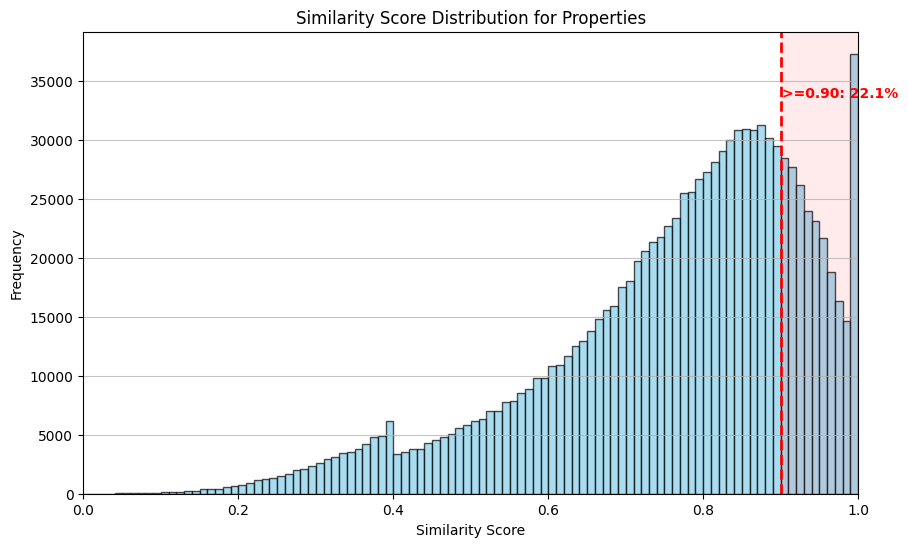

In [35]:
plot_score_distribution(similarity_df, score_col="score", bins=100, threshold=0.9, title="Similarity Score Distribution for Properties")

In [ ]:
comparables_exploded = (
    df_with_comparables
    .select(["id", "comparable_ids"])
    .explode("comparable_ids")
    .rename({"comparable_ids": "comparable_id"})
    .filter(pl.col("comparable_id").is_not_null())
    .sort(by=["id", "comparable_id"], descending=[False, False])
)


In [ ]:
comparables_exploded.head()

id,comparable_id
u32,u32
7,10
7,25
7,26
7,130281
8,11


In [ ]:
random_id = (
    comparables_exploded
    .select("id")
    .unique()
    .sample(n=1)
    .item()
)
random_id

101713

In [ ]:
ids_to_keep = (
    pl.concat([
        comparables_exploded
        .filter(pl.col("id") == random_id)
        .select(pl.col("comparable_id").alias("id")),
        pl.DataFrame(
            {"id": [random_id]},
            schema={"id": pl.UInt32}
        )
    ])
    .unique()
    .sort(by="id", descending=False)
    .to_series()
)

ids_to_keep


id
u32
101661
101713
101720
101760
101785
101797
101799
101800
101801


In [ ]:
df_with_comparables.filter(
    pl.col("id").is_in(ids_to_keep.implode())
)

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,h3_id,h3_grid,comparable_ids
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,str,list[str],list[u32]
101661,145337849,"""Departamento en Venta en Iztac…","""Hermoso departamento en VENTA …","""sale""","""2024-12-21 16:54:09""","""Luxolty Real Estate""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.401809,-99.106984,"""Chicle,Granjas México,Iztacalc…","""MXN""",2853143,57.0,57.0,null,"""A estrenar""",null,2,2,null,"""1""","""Chicle""",null,null,"""Granjas México""",null,"""Iztacalco""","""Iztacalco""","""Ciudad de México""","""Mexico""",null,null,null,"""Granjas México""","""Ciudad de México""","""2025-12-15 15:58:50""","""{""Mascotas"": true, ""Estado de …","""52 5544782850""",0,"""LAP6516857""","""3""","""5.0""","""5.0""","""5.0""","""2""",null,null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA EN IZTAC…","""HERMOSO DEPARTAMENTO EN VENTA …","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",false,null,0,"""{""mascotas"": ""true"", ""estado_d…","{null,null,""true"",null,null,null}",null,null,true,null,null,null,"""894995bb013ffff""","[""894995bb013ffff"", ""894995bb0c7ffff"", … ""894995bb08bffff""]","[101713, 101720, … 101797]"
101713,146955261,"""Departamento en Venta Para Est…","""Hermosos departamentos super u…","""sale""","""2025-07-09 15:27:36""","""Rosalba Arroyo SI""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.401809,-99.106984,"""Chicle ,granjas México Iztaca…","""MXN""",2947143,57.0,57.0,null,"""A estrenar""",null,2,2,null,"""1""","""Chicle ,granjas México Iztaca…",null,null,"""Granjas México""",null,"""Iztacalco""","""Iztacalco""","""Ciudad de México""","""Mexico""",null,null,null,"""Granjas México""","""Ciudad de México""","""2025-12-15 15:58:07""","""{""Mascotas"": true, ""Cocina int…",null,0,"""RAP6809536""","""3""","""5.0""","""5.0""","""5.0""","""1""",null,null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA PARA EST…","""HERMOSOS DEPARTAMENTOS SUPER U…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",false,null,0,"""{""mascotas"": ""true"", ""cocina_i…","{null,null,null,null,null,null}",null,null,null,null,null,null,"""894995bb013ffff""","[""894995bb013ffff"", ""894995bb0c7ffff"", … ""894995bb08bffff""]","[101661, 101720, … 101797]"
101720,145908454,"""Departamento en Granjas Mexico…","""Hermoso departamento ubicado e…","""sale""","""2025-03-09 09:19:21""","""Alfa Inmobiliaria House Infini…","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.401809,-99.106984,"""CHICLE,Granjas México,Iztacalc…","""MXN""",2917857,52.0,52.0,null,"""2024""",null,2,2,null,null,"""CHICLE""",null,null,"""Granjas México""",null,"""Iztacalco""","""Iztacalco""","""Ciudad de México""","""Mexico""",null,null,null,"""Granjas México""","""Ciudad de México""","""2025-12-14 16:08:30""","""{""Gimnasio"": true}""","""52 5592160909""",0,"""6040F4""","""4""","""5

In [ ]:
comparables_exploded

# Clean description

In [ ]:
import polars as pl
import re


# Spanish stop words for real estate context
SPANISH_STOP_WORDS = {
    # Articles
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    # Prepositions
    "a", "ante", "bajo", "con", "contra", "de", "desde", "en", "entre", 
    "hacia", "hasta", "para", "por", "segun", "sin", "sobre", "tras",
    # Conjunctions
    "y", "e", "o", "u", "pero", "sino", "aunque", "si", "porque", "cuando",
    # Pronouns
    "yo", "tu", "el", "ella", "nosotros", "vosotros", "ellos", "ellas",
    "me", "te", "se", "nos", "os", "le", "les", "lo", "los", "la", "las",
    "mi", "tu", "su", "nuestro", "vuestro", "suyo",
    "este", "esta", "estos", "estas", "ese", "esa", "esos", "esas",
    "aquel", "aquella", "aquellos", "aquellas",
    "que", "cual", "quien", "cuanto",
    # Common verbs (to be, to have)
    "es", "son", "esta", "estan", "ser", "estar", "hay",
    "tiene", "tienen", "tener",
    # Other common words
    "del", "al", "muy", "mas", "menos", "tambien", "como", "donde",
    "todo", "toda", "todos", "todas",
}

# Marketing fluff phrases (common in real estate)
MARKETING_PHRASES = [
    "DESCUBRE TU NUEVO HOGAR",
    "BIENVENIDO A",
    "NO PIERDAS LA OPORTUNIDAD",
    "CONTACTANOS HOY",
    "VEN A CONOCERLA",
    "TE ENCANTARA",
    "SOLO TE PREOCUPAS DE LAS FIRMAS",
    "MAS QUE UNA CORREDORA",
    "LOS BENEFICIOS DE COMPRAR CON NOSOTROS",
    "TE LO HACEMOS MAS FACIL Y SEGURO",
    "ESTILO DE VIDA EXCEPCIONAL",
    "DAR EL PRIMER PASO",
    "SER PARTE DE ESTA EXCLUSIVA COMUNIDAD",
]


def remove_legal_disclaimers(text: str) -> str:
    """Remove legal disclaimers and boilerplate text."""
    
    patterns = [
        # NOTA disclaimers
        r"NOTA:\s*EL\s+COMPRADOR.*?ADQUISICION\.?",
        # Furniture disclaimers
        r"\*?\s*SE\s+VENDE\s+SIN\s+MUEBLES.*?INMUEBLE\.?\s*\*?",
        # Tax disclaimers
        r"\*?\s*LOS\s+GASTOS\s+E\s+IMPUESTOS.*?VENTA\.?\s*\*?",
        # Measurement disclaimers
        r"\*?\s*LAS\s+MEDIDAS\s+SON\s+APROXIMADAS.*?INMOBILIARIA\.?\s*\*?",
        # Privacy disclaimers
        r"\*?\s*CONSULTA\s+AVISO\s+DE\s+PRIVACIDAD.*?OFICIAL\.?\s*\*?",
        # Price disclaimers
        r"\*?\s*LOS\s+PRECIOS\s+PUBLICADOS.*?INMOBILIARIA\.?\s*\*?",
        # Terms and conditions
        r"\*?\s*APLICAN\s+T&C\s*\*?",
        # Requirements sections
        r"REQUISITOS.*?(?=\n|$)",
    ]
    
    for pattern in patterns:
        text = re.sub(pattern, " ", text, flags=re.IGNORECASE | re.DOTALL)
    
    return text


def remove_internal_codes(text: str) -> str:
    """Remove internal codes and IDs."""
    
    patterns = [
        r"CLAVE\s+INT[:/]\s*[\w\d]+",
        r"CLAVE\s+INTERNA:\s*[\w\d]+",
        r"ID\s+HOUM:\s*[\w\d]+",
        r"\[VEN\]",
        r"VER\s+DATOS",
    ]
    
    for pattern in patterns:
        text = re.sub(pattern, " ", text, flags=re.IGNORECASE)
    
    return text


def remove_marketing_fluff(text: str) -> str:
    """Remove common marketing phrases that add no semantic value."""
    
    for phrase in MARKETING_PHRASES:
        text = re.sub(re.escape(phrase), " ", text, flags=re.IGNORECASE)
    
    # Remove excessive exclamations and questions
    text = re.sub(r"[!¡]{2,}", " ", text)
    text = re.sub(r"[?¿]{2,}", " ", text)
    
    return text


def remove_special_characters(text: str) -> str:
    """Remove bullets, asterisks, and other special characters."""
    
    # Remove bullet points
    text = re.sub(r"[•●○◦▪▫‣⁃]", " ", text)
    
    # Remove excessive asterisks
    text = re.sub(r"\*{2,}", " ", text)
    text = re.sub(r"^\*\s*", "", text, flags=re.MULTILINE)
    text = re.sub(r"\s*\*$", "", text, flags=re.MULTILINE)
    
    # Remove dashes used as separators
    text = re.sub(r"[\-–—]{2,}", " ", text)
    
    return text


def remove_stop_words(text: str) -> str:
    """Remove Spanish stop words."""
    
    # Split into words
    words = text.split()
    
    # Filter out stop words
    filtered_words = [
        word for word in words 
        if word.lower() not in SPANISH_STOP_WORDS and len(word) > 1
    ]
    
    return " ".join(filtered_words)


def clean_description_for_embeddings(text: str) -> str:
    """
    Complete cleaning pipeline for real estate descriptions.
    Optimized for embedding-based similarity search.
    
    Steps:
    1. Remove legal disclaimers
    2. Remove internal codes
    3. Remove marketing fluff
    4. Remove special characters
    5. Remove emojis
    6. Normalize unicode (remove accents)
    7. Convert to uppercase
    8. Remove stop words
    9. Clean up whitespace
    """
    
    if not text or pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Step 1: Remove legal disclaimers
    text = remove_legal_disclaimers(text)
    
    # Step 2: Remove internal codes
    text = remove_internal_codes(text)
    
    # Step 3: Remove marketing fluff
    text = remove_marketing_fluff(text)
    
    # Step 4: Remove special characters
    text = remove_special_characters(text)
    
    # Step 5: Remove emojis
    emoji_pattern = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+"
    text = re.sub(emoji_pattern, " ", text)
    
    # Step 6: Normalize unicode (remove accents)
    # á -> a, é -> e, í -> i, ó -> o, ú -> u, ñ -> n
    import unicodedata
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ASCII', 'ignore').decode('ASCII')
    
    # Step 7: Convert to uppercase
    text = text.upper()
    
    # Step 9: Remove all punctuation
    text = re.sub(r"[.,;:!?¡¿()\[\]{}\"\'/\\]", " ", text)
    
    # Step 10: Clean up whitespace
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    
    return text


def clean_real_estate_dataframe(
    df: pl.DataFrame, 
    description_col: str = "description_clean",
    output_col: str = "description_embeddings_clean"
) -> pl.DataFrame:
    """
    Clean real estate dataframe for embedding generation.
    
    Parameters:
    -----------
    df : pl.DataFrame
        Input dataframe
    description_col : str
        Name of the description column
        
    Returns:
    --------
    pl.DataFrame
        Dataframe with cleaned descriptions and quality metrics
    """
    
    # Apply cleaning function
    df_clean = df.with_columns([
        pl.col(description_col).map_elements(
            clean_description_for_embeddings,
            return_dtype=pl.Utf8
        ).alias(output_col),
        pl.col(description_col).str.len_chars().alias("original_length")
    ])

    # Add quality metrics - FIRST create clean_length
    df_clean = df_clean.with_columns([
        pl.col(output_col).str.len_chars().alias("clean_length"),
        (pl.col(output_col).str.len_chars() == 0).alias("is_empty"),
        (pl.col(output_col).str.len_chars() < 50).alias("is_too_short"),
    ])
    
    # THEN calculate reduction_ratio (now clean_length exists)
    df_clean = df_clean.with_columns([
        (
            (pl.col("original_length") - pl.col("clean_length")) 
            / pl.col("original_length")
        ).alias("reduction_ratio")
    ])
    
    return df_clean


def print_cleaning_report(df: pl.DataFrame) -> None:
    """Print a report on cleaning quality."""
    
    total = len(df)
    empty = df.filter(pl.col("is_empty")).shape[0]
    too_short = df.filter(pl.col("is_too_short")).shape[0]
    
    print("="*60)
    print("CLEANING REPORT")
    print("="*60)
    print(f"Total records: {total}")
    print(f"Empty after cleaning: {empty} ({empty/total*100:.1f}%)")
    print(f"Too short (<50 chars): {too_short} ({too_short/total*100:.1f}%)")
    print(f"Avg original length: {df['original_length'].mean():.0f} chars")
    print(f"Avg clean length: {df['clean_length'].mean():.0f} chars")
    print(f"Avg reduction: {df['reduction_ratio'].mean()*100:.1f}%")
    print("="*60)


def show_cleaning_examples(
    df: pl.DataFrame, n: int = 3,
    original_col: str = "description_clean",
    output_col: str = "description_embeddings_clean"
    ) -> None:
    """Show before/after examples of cleaning."""
    
    print("\n" + "="*60)
    print("CLEANING EXAMPLES")
    print("="*60)
    
    for i in range(min(n, len(df))):
        row = df[i]
        print(f"\n--- EXAMPLE {i+1} ---")
        print(f"\nORIGINAL ({row['original_length'][0]} chars):")
        print(row[original_col][0][:300] + "..." if len(row[original_col][0]) > 300 else row[original_col][0])
        print(f"\nCLEANED ({row['clean_length'][0]} chars):")
        print(row[output_col][0][:300] + "..." if len(row[output_col][0]) > 300 else row[output_col][0])
        print(f"\nReduction: {row['reduction_ratio'][0]*100:.1f}%")

In [ ]:
# Clean the dataframe
df_clean = clean_real_estate_dataframe(h3_data, description_col="description_clean")

# Show report
print_cleaning_report(df_clean)

# Show examples
show_cleaning_examples(df_clean, n=3, original_col="description_clean",output_col="description_embeddings_clean")

CLEANING REPORT
Total records: 138310
Empty after cleaning: 10 (0.0%)
Too short (<50 chars): 309 (0.2%)
Avg original length: 939 chars
Avg clean length: 908 chars
Avg reduction: nan%

CLEANING EXAMPLES

--- EXAMPLE 1 ---

ORIGINAL (1810 chars):
UBICACION PRIVILEGIADA, LUJO ACCESIBLE Y PLUSVALIA ASEGURADA VIVE O INVIERTE EN EL CORAZON DE TEMOZON NORTE, LA ZONA DE MAYOR CRECIMIENTO Y PLUSVALIA DE MERIDA. RODEADO DE UNIVERSIDADES, HOSPITALES, SUPERMERCADOS Y PLAZAS COMERCIALES, ESTE DESARROLLO SE CONVIERTE EN LA OPCION IDEAL PARA QUIENES BUSC...

CLEANED (1735 chars):
UBICACION PRIVILEGIADA LUJO ACCESIBLE Y PLUSVALIA ASEGURADA VIVE O INVIERTE EN EL CORAZON DE TEMOZON NORTE LA ZONA DE MAYOR CRECIMIENTO Y PLUSVALIA DE MERIDA RODEADO DE UNIVERSIDADES HOSPITALES SUPERMERCADOS Y PLAZAS COMERCIALES ESTE DESARROLLO SE CONVIERTE EN LA OPCION IDEAL PARA QUIENES BUSCAN CAL...

Reduction: 4.1%

--- EXAMPLE 2 ---

ORIGINAL (680 chars):
DEPARTAMENTO CEIBA – VENTA EN TEMOZON NORTE, MERIDA DISENO COMPAC

In [ ]:
df_clean.head()

id,id_ext,title,description,operation_type,publication_date,publisher_name,publisher_type,property_type_raw,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count,property_type,title_clean,description_clean,property_type_clean,source_listing_url_clean,is_development,id_dev,is_remate,amenidades_normalized,amen_raw,jacuzzi,alberca,gimnasio,salonusosmultiples,elevador,asador,h3_id,h3_grid,description_embeddings_clean,original_length,clean_length,is_empty,is_too_short,reduction_ratio
u32,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,f64,f64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,bool,str,i8,str,struct[6],bool,bool,bool,bool,bool,bool,str,list[str],str,u32,u32,bool,bool,f64
1,147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,48.0,52.0,null,null,null,null,null,null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40,"""DEPARTAMENTO""","""DESARROLLO INMOBILARIO EN VENT…","""UBICACION PRIVILEGIADA, LUJO A…","""DEPARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{""portabicicletas"": ""true"", ""r…","{null,""true"",""true"",null,""1"",null}",null,true,true,null,true,null,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]","""UBICACION PRIVILEGIADA LUJO AC…",1810,1735,false,false,0.041436
2,147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,48.0,52.0,null,"""En construcción""",null,1,1,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null,"""DEPARTAMENTO""","""DEPARTAMENTO EN VENTA DE 1 REC…","""DEPARTAMENTO CEIBA – VENTA EN …","""DESARROLLO-APARTAMENTO""","""HTTPS://WWW.INMUEBLES24.COM/PR…",true,"""ememvein-zentia-temozon-norte""",0,"""{}""","{null,null,null,null,null,null}",null,null,null,null,null,null,"""894509a35c7ffff""","[""894509a35c7ffff"", ""894509a35c3ffff"", … ""894509a35d7ffff""]","""DEPARTAMENTO CEIBA VENTA EN TE…",680,656,false,false,0.035294
3,147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,64.0,64.0,null,"""En construcción""",null,2,2,null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mér

# Generate embeddings

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create vectorizer
vectorizer = TfidfVectorizer(
    max_features=500,  # Only keep top 500 words
    ngram_range=(1, 2)  # Unigrams and bigrams
)

# Fit and transform
texts = df_clean["description_embeddings_clean"].to_list()
embeddings = vectorizer.fit_transform(texts)  # Sparse matrix

# Convert to dense for similarity (optional)
embeddings_dense = embeddings.toarray()  # Shape: (138310, 500)

# Find similar listings
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embeddings[0:1], embeddings)[0]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ============================================================
# OPTION 1: CLEANED DATA (what you already have)
# ============================================================
print("="*60)
print("TF-IDF WITH CLEANED DATA (stop words removed, no punctuation)")
print("="*60)

# Create vectorizer for cleaned data
vectorizer_clean = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2)
)

# Fit and transform cleaned texts
texts_clean = df_clean["description_embeddings_clean"].to_list()
embeddings_clean = vectorizer_clean.fit_transform(texts_clean)

print(f"Shape: {embeddings_clean.shape}")
print(f"Non-zero elements: {embeddings_clean.nnz}")
print(f"Sparsity: {(1 - embeddings_clean.nnz / (embeddings_clean.shape[0] * embeddings_clean.shape[1])) * 100:.2f}%")

TF-IDF WITH CLEANED DATA (stop words removed, no punctuation)
Shape: (138310, 500)
Non-zero elements: 10049803
Sparsity: 85.47%


In [ ]:

# Find similar listings to first listing
# query_idx = 7 # all are devlopments
query_idx = 18877
similarities_clean = cosine_similarity(embeddings_clean[query_idx:query_idx+1], embeddings_clean)[0]
top_10_clean = np.argsort(similarities_clean)[::-1][:11]  # Top 11 (includes itself)

print(f"\nQuery listing (index {query_idx}):")
print(f"Title: {df_clean['title'][query_idx]}")
print(f"Cleaned: {texts_clean[query_idx][:200]}...")

print("\nTop 10 most similar listings (CLEANED):")
for rank, idx in enumerate(top_10_clean[1:], 1):  # Skip first (itself)
    idx = int(idx)  # <-- FIX: Convert numpy.int64 to Python int
    print(f"{rank}. Index {idx} - Similarity: {similarities_clean[idx]:.4f}")
    print(f"   Title: {df_clean['title'][idx]}")
    print(f"   Clean text: {texts_clean[idx][:150]}...")
    print()


Query listing (index 18877):
Title: Casa en Venta en Lomas de La Herradura, Edo. de México
Cleaned: CJC-816 CASA TOTALMENTE REMODELADA Y ACTUALIZADA CON ACABADOS DE PRIMERA CALIDAD EN LA HERRADURA UNA ZONA TRANQUILA Y SEGURA CON CALLES ARBOLADAS UBICADA EN CALLE CERRADA CON CASETA DE VIGILANCIA Y DO...

Top 10 most similar listings (CLEANED):
1. Index 37051 - Similarity: 0.5797
   Title: Casa en Venta en La Calma - Pedro Simón Laplace 3646, Jalisco
   Clean text: EN VENTA CASA UBICADA EN LA CALMA PEDRO SIMON LAPLACE CON UNA EXCELENTE DISTRIBUCION Y ACABADOS DE ALTA CALIDAD LA PROPIEDAD CUENTA CON UN TERRENO DE ...

2. Index 124159 - Similarity: 0.5748
   Title: Juriquilla: Oportunidad!, Estupenda Residencia en Privada, Provincia de Querétaro
   Clean text: LINDISIMA RESIDENCIA EN PRIVADA PUNTA ROCA MUY LINDO PROYECTO COMODOS ESPACIOS EXCELENTEMENTE CONSTRUIDA EN DOS PLANTAS EN PLANTA ALTA TENEMOS TRES RE...

3. Index 63884 - Similarity: 0.5649
   Title: Casa Nueva en Venta en Metepec 

In [ ]:

# ============================================================
# OPTION 2: ORIGINAL DATA (uncleaned)
# ============================================================
print("\n" + "="*60)
print("TF-IDF WITH ORIGINAL DATA (with stop words, punctuation, accents)")
print("="*60)

# Create vectorizer for original data
vectorizer_original = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2)
)

# Fit and transform original texts
texts_original = df_clean["description_clean"].to_list()  # Your original description_clean column
embeddings_original = vectorizer_original.fit_transform(texts_original)

print(f"Shape: {embeddings_original.shape}")
print(f"Non-zero elements: {embeddings_original.nnz}")
print(f"Sparsity: {(1 - embeddings_original.nnz / (embeddings_original.shape[0] * embeddings_original.shape[1])) * 100:.2f}%")

# Find similar listings to same listing
similarities_original = cosine_similarity(embeddings_original[query_idx:query_idx+1], embeddings_original)[0]
top_10_original = np.argsort(similarities_original)[::-1][:11]

print(f"\nQuery listing (index {query_idx}):")
print(f"Title: {df_clean['title'][query_idx]}")
print(f"Original: {texts_original[query_idx][:200]}...")

print("\nTop 10 most similar listings (ORIGINAL):")
for rank, idx in enumerate(top_10_original[1:], 1):
    print(f"{rank}. Index {idx} - Similarity: {similarities_original[idx]:.4f}")
    print(f"   Title: {df_clean['title'][idx]}")
    print(f"   Original text: {texts_original[idx][:150]}...")
    print()

# ============================================================
# COMPARISON: OVERLAP ANALYSIS
# ============================================================
print("\n" + "="*60)
print("COMPARISON: How different are the results?")
print("="*60)

# Get top 20 from each (excluding query itself)
top_20_clean_set = set(top_10_clean[1:21]) if len(top_10_clean) > 20 else set(top_10_clean[1:])
top_20_original_set = set(top_10_original[1:21]) if len(top_10_original) > 20 else set(top_10_original[1:])

# Calculate overlap
overlap = top_20_clean_set & top_20_original_set
only_in_clean = top_20_clean_set - top_20_original_set
only_in_original = top_20_original_set - top_20_clean_set

print(f"Overlap in top 20: {len(overlap)}/20 ({len(overlap)/20*100:.1f}%)")
print(f"Only in cleaned: {len(only_in_clean)}")
print(f"Only in original: {len(only_in_original)}")

if only_in_clean:
    print("\nListings found ONLY with cleaned data:")
    for idx in list(only_in_clean)[:5]:
        print(f"  - Index {idx}: {df_clean['title'][idx][:80]}")

if only_in_original:
    print("\nListings found ONLY with original data:")
    for idx in list(only_in_original)[:5]:
        print(f"  - Index {idx}: {df_clean['title'][idx][:80]}")

# ============================================================
# VOCABULARY COMPARISON
# ============================================================
print("\n" + "="*60)
print("VOCABULARY COMPARISON")
print("="*60)

vocab_clean = set(vectorizer_clean.get_feature_names_out())
vocab_original = set(vectorizer_original.get_feature_names_out())

print(f"Cleaned vocabulary size: {len(vocab_clean)}")
print(f"Original vocabulary size: {len(vocab_original)}")
print(f"Unique to cleaned: {len(vocab_clean - vocab_original)}")
print(f"Unique to original: {len(vocab_original - vocab_clean)}")

print("\nTop 20 words in cleaned vocabulary:")
feature_importances_clean = np.asarray(embeddings_clean.sum(axis=0)).flatten()
top_features_clean = np.argsort(feature_importances_clean)[::-1][:20]
for idx in top_features_clean:
    print(f"  - {vectorizer_clean.get_feature_names_out()[idx]}")

print("\nTop 20 words in original vocabulary:")
feature_importances_original = np.asarray(embeddings_original.sum(axis=0)).flatten()
top_features_original = np.argsort(feature_importances_original)[::-1][:20]
for idx in top_features_original:
    print(f"  - {vectorizer_original.get_feature_names_out()[idx]}")

# ============================================================
# PERFORMANCE METRICS
# ============================================================
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

import time

# Test encoding speed for cleaned
start = time.time()
_ = vectorizer_clean.transform(texts_clean[:1000])
time_clean = time.time() - start

# Test encoding speed for original
start = time.time()
_ = vectorizer_original.transform(texts_original[:1000])
time_original = time.time() - start

print(f"Time to encode 1000 texts (cleaned): {time_clean:.3f}s")
print(f"Time to encode 1000 texts (original): {time_original:.3f}s")
print(f"Speedup: {time_original/time_clean:.2f}x")

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
chunk_size = 50_000  # tune to your RAM
out_dir = "emb_parts"

df = df_clean

for i, chunk in enumerate(df.iter_slices(n_rows=chunk_size)):
    ids = chunk["id"]
    texts = chunk["description_embeddings_clean"].to_list()

    emb = model.encode(
        texts,
        batch_size=256,              # usually larger is faster if RAM allows
        normalize_embeddings=True,
        convert_to_numpy=True,
        show_progress_bar=(i == 0),
    ).astype(np.float32)

    d = emb.shape[1]
    out = pl.DataFrame({
        "id": ids,
        "embedding": pl.Series("embedding", emb, dtype=pl.Array(pl.Float32, d)),
    })

    out.write_parquet(f"{out_dir}/part-{i:05d}.parquet")

In [ ]:
# Original data (lazy)
df_lz = df_clean.lazy()

# All embedding shards (lazy)
emb_lz = pl.scan_parquet("emb_parts/*.parquet")

# Join on your existing id
df_with_emb = (
    df_lz
    .join(emb_lz, on="id", how="left")
    .collect(streaming=True)  # streaming helps keep memory down
)

In [ ]:
# Example: Find similar listings to listing at index 0
query_embedding = embeddings[0]

# Compute similarities to all other listings
similarities = np.dot(embeddings, query_embedding)

# Get top 10 most similar (excluding itself)
top_indices = np.argsort(similarities)[::-1][1:11]  # Skip index 0 (itself)

print("Top 10 similar listings:")
for idx in top_indices:
    print(f"Index {idx}: Similarity {similarities[idx]:.3f}")
    print(f"  {df_clean['title'][idx]}")
    print()

In [ ]:
pl.Config.set_fmt_str_lengths(10_000)

In [ ]:
h3_data.select(["title","description_clean"])

# Create tasks functions

In [ ]:
def load_dataframes(path: str) -> dict[str:str]:
    """
    List ZIPs under S3 prefix -> download -> read each CSV with Polars
    -> standardize (cast/unique/drop-nulls/zip_code clean + column subset)
    -> union per source -> align schema -> write Parquet per source.
    Returns {source_name: parquet_path}.
    """
    # import os
    # import tempfile
    # import zipfile
    # import pandas as pd

    # Map to expected polars datatype
    # Integer was quitted due to value differences in amenities
    TEXT, F64, I64 = pl.Utf8, pl.Float64, pl.Int64
    DTYPE_MAP = {
        "id": TEXT,
        "title": TEXT,
        "amenidades": TEXT,
        "approximate_address": TEXT,
        "apt_floor": I64,  # changed to I64 from F64
        "city": TEXT,
        "city_area": TEXT,
        "content": TEXT,
        "country": TEXT,
        "currency": TEXT,  # parse later
        "date_scraped": TEXT,
        "del_mun": TEXT,
        "ext_number": TEXT,
        "int_number": TEXT,
        "main_development_url": TEXT,
        "neighborhood": TEXT,
        "operation_type": TEXT,
        "phone_number": TEXT,
        "property_type": TEXT,
        "publication_date": TEXT,
        "publisher_name": TEXT,
        "publisher_type": TEXT,
        "region": TEXT,
        "source_listing_url": TEXT,
        "source_type": TEXT,
        "state": TEXT,
        "street_name": TEXT,
        "zip_code": TEXT,  # parse later
        "source": TEXT,
        # numeric
        "asking_price": F64,
        "maintenance_fee": F64,
        "lat": F64,
        "lon": F64,
        "m2_balconies": F64,
        "m2_built": TEXT,  # parse later
        "m2_rooftop": F64,
        "m2_terraces": F64,
        "m2_terrain": TEXT,  # parse later
        "no_bedrooms": F64,
        "no_full_bathrooms": F64,
        "no_half_bathrooms": F64,
        "no_parking_spaces": F64,
        "year_built": F64,
    }

    data_folder = Path(path).expanduser().resolve()

    print(f"Data folder: {data_folder}")

    # List all .zip files in the folder
    zip_paths = sorted(
        [p for p in data_folder.iterdir() if p.is_file() and p.suffix.lower() == ".zip"]
    )
    if not zip_paths:
        print(f"No .zip files found in: {data_folder}")
        return {}

    print(f"Processing {len(zip_paths)} ZIP archive(s) from: {data_folder}")

    # Accumulate lazyframes per source; we’ll concat each group once
    by_source: dict[str, list[pl.LazyFrame]] = {}

    for zpath in zip_paths:
        base = zpath.name  # e.g., lamudi_2025-07-01.zip
        source_name, op_upper = _infer_source_and_operation(base)
        print(f"ZIP path: {zpath}")

        try:
            # Extract all CSV files and build one Polars DF per CSV
            with zipfile.ZipFile(zpath) as zf:
                csv_files = [n for n in zf.namelist() if n.lower().endswith(".csv")]
                if not csv_files:
                    print(f"Warning: no CSV files found in {zpath}")
                    continue

                for file in csv_files:
                    csv_base = os.path.basename(file)
                    print(f"[{source_name}] reading CSV file from ZIP: {csv_base}")

                    # Read directly from the zipfile into a LazyFrame
                    lf_raw = _read_csv_lazy_from_zip(
                        zf,
                        file,
                        dtypes=DTYPE_MAP,  # use your known dtypes to avoid inference
                        null_values=["None", "NULL", ""],
                    )

                    # Apply your standardization logic on the existing LazyFrame
                    lf = _standardize_one_source_lazy(
                        lf_raw,
                        source_name=source_name,
                        operation_type_upper=op_upper,
                        common_columns=common_columns,
                    )

                    by_source.setdefault(source_name, []).append(lf)

        except Exception as e:
            print(f"Warning: failed to read {zpath} with Polars: {e}")

    # Now union per source, align schema, and persist as Parquet
    outs: dict[str, str] = {}
    targets = set(common_columns) | {"source"}

    for source_name, lfs in by_source.items():
        if not lfs:
            continue

        # Concatenate all LazyFrames for this source
        lf = pl.concat(lfs, how="vertical")

        # Align schema to uniform dtypes you use downstream
        lf = _align_schema(lf, list(targets), DTYPE_MAP)

        # Persist (small XCom: return only file path)
        file_path = Path(OUT_DIR / f"{source_name}_{published_wave}.parquet")

        df = lf.collect(streaming=True)
        df.write_parquet(file_path)
        outs[source_name] = str(file_path)

        print(f"[{source_name}] standardized rows: {df.height:,} -> {file_path}")
        print(f"Dataframe has been written to {file_path}")

    if not outs:
        return print("No sources produced output parquet.")

    return outs

In [ ]:
out = load_dataframes(fourth_wave_folder)  # ! Need to be set manually

In [ ]:
out

In [ ]:
def clean_and_concatenate(std_paths: dict[str, str]) -> str:
    """
    Read standardized per-source Parquets -> concat -> full cleaning pipeline
    -> write final Parquet and return its path.
    """

    # 1) Read lazily and concat
    lfs = [pl.scan_parquet(path) for path in std_paths.values() if path]
    if not lfs:
        print("No standardized inputs provided to clean_and_concatenate.")
        return ""
    lf = pl.concat(lfs, how="vertical")

    schema_names = set(lf.collect_schema().names())

    # content → description
    if "content" in schema_names:
        lf = lf.rename({"content": "description"})
        schema_names.discard("content")
        schema_names.add("description")

    # Homologate property type to the mapping defined
    if "property_type" in schema_names:
        lf = lf.with_columns(
            pl.coalesce(
                [
                    pl.col("property_type").replace(homologated_mapping),  # case-sensitive
                    pl.col("property_type"),
                ]
            )
            .str.to_uppercase()
            .alias("property_type_homo")
        )
    else:
        lf = lf.with_columns(pl.lit(None, dtype=pl.Utf8).alias("property_type_homo"))

    # Ensure string columns used later exist
    ## If they don't exist, mark as None
    ## Then update the schema (missing columns are present know)
    need_utf8 = [
        "property_type",
        "description",
        "main_development_url",
        "title",
        "source_listing_url",
        "amenidades",
        "publisher_name",
    ]
    missing = [column for column in need_utf8 if column not in schema_names]
    if missing:
        lf = lf.with_columns([pl.lit(None, dtype=pl.Utf8).alias(column) for column in missing])
        schema_names.update(missing)

    # Clean text columns
    ## (?i) == case=False
    ## fill.null(False) == na=false
    preventa_re = r"(?i)\bpreventa(?:s)?\b|\bpre venta(?:s)?\b|\bpre-venta(?:s)?\b"

    lf = lf.with_columns(
        [
            _clean_text_expr("title").alias("title_clean"),
            _clean_text_expr("description").alias("description_clean"),
            _clean_text_expr("property_type").alias("property_type_clean"),
            _clean_text_expr("source_listing_url").alias("source_listing_url_clean"),
        ]
    )

    # Identify developments
    lf = lf.with_columns(
        (
            pl.col("property_type_clean")
            .cast(pl.Utf8)
            .str.contains(r"(?i)desarrollo", literal=False)
            .fill_null(False)
            | pl.col("description_clean")
            .cast(pl.Utf8)
            .str.contains(preventa_re, literal=False)
            .fill_null(False)
            | (pl.col("year_built").cast(pl.Float64, strict=False) >= 2025).fill_null(False)
            | pl.col("main_development_url").cast(pl.Utf8).is_not_null().fill_null(False)
        ).alias("is_development")
    )

    # Extract development id from main_development_url and creates "id_dev"
    lf = lf.with_columns(extract_development_id("main_development_url").alias("id_dev"))

    # Assumes `property_type_homo` already exists (from your earlier mapping step)
    terreno_re = r"(?i)\bterreno(?:s)?\b|\blote(?:s)?\b|\bmacrolote(?:s)?\b"
    casa_re = r"(?i)\bcasa(?:s)?\b"
    is_des = pl.col("property_type").cast(pl.Utf8) == "DESARROLLO"

    # Identifies types of desarrollo
    ## DESARROLLO & (title has terreno/lote/macrolote) -> TERRENO,  otherwise maintains property type
    lf = lf.with_columns(
        pl.when(
            is_des
            & pl.col("title").cast(pl.Utf8).str.contains(terreno_re, literal=False).fill_null(False)
        )
        .then(pl.lit("TERRENO"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    ## DESARROLLO & (title has casa) -> CASA, otherwise maintains property type
    lf = lf.with_columns(
        pl.when(
            is_des
            & pl.col("title").cast(pl.Utf8).str.contains(casa_re, literal=False).fill_null(False)
        )
        .then(pl.lit("CASA"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    ## DESARROLLO -> DEPARTAMENTO, otherwise maintains property type
    lf = lf.with_columns(
        pl.when(is_des)
        .then(pl.lit("DEPARTAMENTO"))
        .otherwise(pl.col("property_type_homo"))
        .alias("property_type_homo")
    )

    # Filter out "remates" but keep "preventa"
    str_filter_remates = (
        r"REMATE|REMATO|PRECIO INMEJORABLE|ATENCION INVERSIONISTA|BAJO CONTRATO|BAJO COSTO|CONTADO|"
        r"COSTO COMERCIAL|COSTO LIQUIDACION|COSTO TOTAL|DE AHORRO|HIPOTECARIA|LIQUIDACION|NO CRED|NO SE ACEPTAN CR|"
        r"NOTARIADO|POR DEBAJO|PRECIO DEBAJO|PRIMER PAGO|RECUPERACION|REMAT|SOLO EFECTIVO|STATUS JURIDICO|TRAMITE|"
        r"UNICA OPORTUNIDAD|INIGUALABLE|OPORTUNIDAD DE INVERS|OPORTUNIDAD DE ADQUIRIR|VALOR AVALUO|VALOR COMERCIAL|"
        r"RECURSOS PROP|SENTENCIA|INVALIDO|JUICIO|ADJUDICA|DESCUENT|RENTA|MITAD DE PRECIO|MITAD-DE-PRECIO|REBAJ|"
        r"PRECIO-ABAJO-DEL|POR DEBAJO DE|POR-DEBAJO|VALOR-CATASTRAL|AL COSTO|AL-COSTO|BAJO DE SU COSTO|% DE SU VALOR COMERCIAL|"
        r"SOBRE SU VALOR COMERCIAL|NO-CRED"
    )
    str_filter_preventa = r"PREVENTA|PRE VENTA|PRE-VENTA|LANZAMIENTO"

    def is_remate(col: str) -> pl.Expr:
        # literal=False -> interpret pattern as regex
        """
        Returns boolean or null for the regex expression.
        Then it fills the nulls into False with fill_null.
        POlars use three-valued logic
        """
        text = pl.col(col).cast(pl.Utf8)
        has_remate = text.str.contains(str_filter_remates, literal=False).fill_null(False)
        has_preventa = text.str.contains(str_filter_preventa, literal=False).fill_null(False)
        is_remate = pl.when(text.is_not_null()).then(has_remate & ~has_preventa).otherwise(False)
        return is_remate

    lf = lf.with_columns(
        (
            is_remate("description_clean")
            | is_remate("title_clean")
            | is_remate("source_listing_url_clean")
        )
        .cast(pl.Int8)
        .alias("is_remate")  # 1 or 0
    )

    # Exclude remates
    lf = lf.filter(pl.col("is_remate") == 0)

    # Exclude specific publishers
    if "publisher_name" in schema_names:
        lf = lf.filter(~pl.col("publisher_name").is_in(["Dimensión Asesores, S.A. de C.V."]))

    # Defining amenidades
    ## Normalize to JSON text (or "{}"), then decode ONLY the canonical fields as booleans
    lf = lf.with_columns(
        pl.when(pl.col("amenidades").is_not_null())
        .then(pl.col("amenidades").map_elements(_normalize_amenidades_json, return_dtype=pl.Utf8))
        .otherwise(pl.lit("{}"))
        .alias("amenidades_normalized")
    )

    # Decode ONLY the 6 canonical keys to a Struct of Utf8 (so empty strings remain visible)
    amen_dtype = pl.Struct(
        {
            "jacuzzi": pl.Utf8,
            "alberca": pl.Utf8,
            "gimnasio": pl.Utf8,
            "salonusosmultiples": pl.Utf8,
            "elevador": pl.Utf8,
            "asador": pl.Utf8,
        }
    )

    lf = lf.with_columns(
        pl.col("amenidades_normalized").str.json_decode(dtype=amen_dtype).alias("amen_raw")
    )

    # 2) Helper: extract JSON key via JSONPath and coerce to boolean with your truthy semantics
    _truthy = {"1", "true", "t", "yes", "y", "si", "sí"}
    _falsey = {"0", "false", "f", "no", "n"}

    def amen_bool(k: str) -> pl.Expr:
        raw = pl.col("amen_raw").struct.field(k)
        s = (
            raw.cast(pl.Utf8, strict=False)
            .str.strip_chars()
            .str.strip_chars('"')
            .str.to_lowercase()
        )
        # num = s.cast(pl.Float64, strict=True) # strict=True raises error
        # Extracts integer/decimal (with . or ,), normalizes to ".", and converts to float
        num = s.str.extract(r"(-?\d+(?:[.,]\d+)?)").str.replace(",", ".").cast(pl.Float64)

        return (
            pl.when(raw.is_null())
            .then(None)  # missing key
            .when(num.is_not_null())
            .then(num > 0)  # Verify position: here or below? "4"/"4.0"/"-1" -> True, "0" -> False
            .when(s == "")
            .then(None)  # empty string -> NULL
            .when(s.is_in(list(_truthy)))
            .then(pl.lit(True))  # textual truthy
            .when(s.is_in(list(_falsey)))
            .then(pl.lit(False))  # textual falsey
            .otherwise(None)
        ).alias(k)

    # 3) Expand desired keys to columns
    lf = lf.with_columns(
        [
            amen_bool("jacuzzi"),
            amen_bool("alberca"),
            amen_bool("gimnasio"),
            amen_bool("salonusosmultiples"),
            amen_bool("elevador"),
            amen_bool("asador"),
        ]
    )

    # 3) Elevador rule (pandas): any non-null value not exactly False -> True; else keep (False/null)
    elevador = pl.col("elevador")
    lf = lf.with_columns(
        pl.when(elevador.is_not_null() & (elevador != pl.lit(False)))
        .then(pl.lit(True))
        .otherwise(elevador)
        .alias("elevador")
    )

    # 12) Final cleaning / renames
    lf = lf.filter(~pl.col("property_type_homo").is_in(["QUINTA", "RANCHO", "RANCHO COMERCIAL"]))
    rename_map = {}
    if "id" in schema_names:
        rename_map["id"] = "id_ext"
    if "property_type" in schema_names:
        rename_map["property_type"] = "property_type_raw"
    rename_map["property_type_homo"] = "property_type"

    lf = lf.rename(rename_map)

    # keep cache in sync
    for old, new in rename_map.items():
        schema_names.discard(old)
        schema_names.add(new)

    # 13) Numeric cleaning for areas
    for metr_col in ["m2_terrain", "m2_built"]:
        if metr_col not in schema_names:
            lf = lf.with_columns(pl.lit(None, dtype=pl.Utf8).alias(metr_col))
            schema_names.add(metr_col)
    num_pat = r"(-?\d+(?:\.\d+)?)"
    lf = lf.with_columns(
        [
            pl.col("m2_terrain")
            .cast(pl.Utf8)
            .str.replace(",", "")
            .str.extract(num_pat)
            .cast(pl.Float64, strict=False)
            .alias("m2_terrain"),
            pl.col("m2_built")
            .cast(pl.Utf8)
            .str.replace(",", "")
            .str.extract(num_pat)
            .cast(pl.Float64, strict=False)
            .alias("m2_built"),
        ]
    )

    # 14) Adjust terrain for DEPARTAMENTO
    lf = lf.with_columns(
        pl.when(
            (pl.col("m2_terrain") < pl.col("m2_built"))
            | (pl.col("m2_terrain").is_null() & (pl.col("property_type") == "DEPARTAMENTO"))
        )
        .then(pl.col("m2_built"))
        .otherwise(pl.col("m2_terrain"))
        .alias("m2_terrain")
    )

    # 15) Sequential id starting at 1
    lf = lf.with_row_index(name="id", offset=1)

    # 16) Final column ordering (append debug columns if present)
    current_cols = set(lf.collect_schema().names())
    final_cols = [c for c in ordered_columns if c in current_cols]

    # Extra cols for debugging amenidades
    # for extra in ("amenidades_normalized", "amen_raw"):
    #     if extra in current_cols and extra not in final_cols:
    #         final_cols.append(extra)

    if final_cols:
        lf = lf.select(final_cols)

    # 13) Materialize + write
    df = lf.collect(engine="streaming")
    # Persist (small XCom: return only file path)
    file_path = Path(OUT_DIR / f"cleaned_listings_{published_wave}.parquet")
    df.write_parquet(file_path)

    print(f"[clean_and_concatenate] rows={df.height:,}, cols={len(df.columns)}")
    print(f"[clean_and_concatenate] wrote: {file_path}")

    return str(file_path)

In [ ]:
print(out)

In [ ]:
clean_listings = clean_and_concatenate(std_paths=out)

In [ ]:
clean_listings

# Start log generating

## Load new data

In [ ]:
new_data = pd.read_parquet(clean_listings)

In [ ]:
new_data.shape

In [ ]:
new_data.info()

## Load logs data from database

In [ ]:
with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    df = pd.read_sql_query(
        text('SELECT * FROM "dbt_dev_julian"."backfill_logs_data" LIMIT 1'),
        conn,
    )
    print("✅ DB connection OK")
    print("Sample row fetched:", not df.empty)

In [ ]:
query = sa.text('SELECT * FROM "dbt_dev_julian"."backfill_logs_data"')
with engine.connect().execution_options(isolation_leval="AUTOCOMMIT") as conn:
    backuped_logs = pd.read_sql_query(query, conn)

In [ ]:
backuped_logs.shape

In [ ]:
backuped_logs.info()

## Generate logs

In [ ]:
print_tree(path=cwd / "data")

In [ ]:
print(published_wave)

In [ ]:
new_wave = published_wave
print(f"New wave is:  {new_wave}")
old_wave = "2025-06-17"  # ! This variable need to be set manually = published_wave minus one
print(f"Last wave is: {old_wave}")

In [ ]:
def generate_logs_table(
    backuped_result: pd.DataFrame,
    cleaned_listings_data: pd.DataFrame,
    tracked_fields: list[str],
    new_wave: str,
    old_wave: str,
) -> pd.DataFrame:
    """
    Build a change log table comparing old_data (from backuped_result) vs new_data (cleaned_listings_data),
    for the tracked_fields and the intersection of id_ext values.

    Args:
        backuped_result: pandas DataFrame, e.g. pd.read_sql("SELECT * FROM dbt_dev_julian.backfill_logs_data", conn)
        cleaned_listings_data: pandas DataFrame, e.g. pd.read_parquet(cleaned_listings_data)
        tracked_fields: list of column names to track/diff
        new_wave: string label for the current wave (e.g. "2025-10-14")
        old_wave: string label for the previous/lagged wave (e.g. "2025-10-07")

    Returns:
        pandas DataFrame with columns (if present in inputs):
        id_ext, source_type, asking_price, currency, m2_built, m2_terrain, lat, lon,
        no_bedrooms, no_full_bathrooms, no_half_bathrooms, no_parking_spaces, year_built,
        wave_date, change_type ∈ {"changed", "new"}
    """

    if not isinstance(backuped_result, pd.DataFrame):
        raise ValueError("[generate_logs_table] 'backuped_result' must be a pandas DataFrame")

    if not isinstance(cleaned_listings_data, pd.DataFrame):
        raise ValueError("[generate_logs_table] 'cleaned_listings_data' must be a pandas DataFrame")

    if not isinstance(tracked_fields, (list, tuple)) or not all(
        isinstance(x, str) for x in tracked_fields
    ):
        raise ValueError("[generate_logs_table] 'tracked_fields' must be a list[str]")

    if not isinstance(new_wave, str) or not isinstance(old_wave, str):
        raise ValueError("[generate_logs_table] 'new_wave' and 'old_wave' must be strings")

    # Convert to Polars for fast columnar ops
    lf_new = pl.from_pandas(cleaned_listings_data)

    for column in lf_new.columns:
        print(column)

    lf_old_full = pl.from_pandas(backuped_result)

    # Ensure id_ext exists in both
    if "id_ext" not in lf_new.columns:
        raise ValueError("[new_data] missing required column 'id_ext'")
    if "id_ext" not in lf_old_full.columns:
        raise ValueError("[backuped_logs] missing required column 'id_ext'")

    # Columns we want to track in the logs table
    cols_to_logs_table = [
        "id_ext",
        "source_type",
        "asking_price",
        "currency",
        "m2_built",
        "m2_terrain",
        "lat",
        "lon",
        "no_bedrooms",
        "no_full_bathrooms",
        "no_half_bathrooms",
        "no_parking_spaces",
        "year_built",
        "wave_date",
    ]
    # Keep only columns present in new_data to avoid schema errors
    cols_present_new = [c for c in cols_to_logs_table if c in lf_new.columns or c == "wave_date"]

    # OLD SNAPSHOT: select comparable columns from backup (only what's present)
    wanted_cols = ["id_ext", "source_type"] + list(tracked_fields)
    present_in_old = [c for c in wanted_cols if c in lf_old_full.columns]
    missing_in_old = [c for c in wanted_cols if c not in lf_old_full.columns]

    if missing_in_old:
        print(f"[backuped_logs] missing columns (info): {missing_in_old}")

    if "wave_date" not in lf_old_full.columns:
        raise ValueError("[backuped_logs] needs 'wave_date' (YYYY-MM-DD) to pick previous state")

    # This was overwriting wave date, but luckylily snapshot old was resetted so it did not have a change in the code
    # snapshot_old = lf_old_full.select(present_in_old).with_columns(
    #     pl.lit(old_wave).alias("wave_date")
    # )

    # Select only the last wave to compare
    ##  Cast to polars date to ensure right comparision
    lf_old_full = lf_old_full.with_columns(
        pl.col("wave_date").cast(pl.Utf8).str.strptime(pl.Date, strict=False)
    )

    # 2) Keep only rows at/before old_wave
    _old_cutoff = _date.fromisoformat(old_wave)
    old_filtered = (
        lf_old_full
        # Keep dates that are equal or more old that the cutoff
        .filter(pl.col("wave_date") <= pl.lit(_old_cutoff, dtype=pl.Date))
    )
    snapshot_old = (
        old_filtered
        # id_ext = ascending
        # wave_date = descending
        # For each id_ext, its most recent row appears first
        # Push null values to the end
        .sort(by=["id_ext", "wave_date"], descending=[False, True], nulls_last=True)
        .select(present_in_old + ["wave_date"])
        # keep the first row, that is the most recent because we sorted it
        .unique(subset=["id_ext"], keep="first")
        .drop("wave_date")
    )

    print(
        f"[logs] full_backup (all log waves)\n -> rows={lf_old_full.height}, unique ids={lf_old_full.select(pl.col('id_ext').n_unique()).item()}"
    )
    print(
        f"[logs] snapshot_old (last comparable wave)\n -> rows={snapshot_old.height}, unique ids={snapshot_old.select(pl.col('id_ext').n_unique()).item()}"
    )
    print(f"[logs] snapshot_old schema: {snapshot_old.schema}")

    # Find intersections and new-only ids
    old_ids_df = snapshot_old.select("id_ext").drop_nulls().unique()
    keep_published = lf_new.join(old_ids_df, on="id_ext", how="semi")
    keep_published_ids = keep_published.select("id_ext").drop_nulls().unique().get_column("id_ext")

    published = lf_new.join(old_ids_df, on="id_ext", how="anti")
    new_only_ids = published.select("id_ext").drop_nulls().unique().get_column("id_ext")

    # Build new snapshot with ids to compare/log
    new_ids = pl.concat([keep_published_ids, new_only_ids]).unique(maintain_order=True)
    snapshot_new = lf_new.filter(pl.col("id_ext").is_in(new_ids.implode())).select(
        [c for c in (["id_ext", "source_type"] + list(tracked_fields)) if c in lf_new.columns]
    )

    # Normalization for numerics (null-safe comparisons & rounding)
    numeric_tracked = [
        "asking_price",
        "m2_built",
        "m2_terrain",
        "lat",
        "lon",
        "no_bedrooms",
        "no_full_bathrooms",
        "no_half_bathrooms",
        "no_parking_spaces",
        "year_built",
    ]

    def _norm_numeric(df: pl.DataFrame) -> pl.DataFrame:
        return df.with_columns(
            [
                pl.col(c).cast(pl.Float64, strict=False).fill_nan(None).alias(c)
                for c in numeric_tracked
                if c in df.columns
            ]
        )

    def _round_cols(df: pl.DataFrame) -> pl.DataFrame:
        return df.with_columns(
            [
                pl.col(c).cast(pl.Float64, strict=False).round(6).alias(c)
                for c in numeric_tracked
                if c in df.columns
            ]
        )

    snapshot_old = _round_cols(_norm_numeric(snapshot_old))
    snapshot_new = _round_cols(_norm_numeric(snapshot_new)).with_columns(
        pl.lit(new_wave).alias("wave_date")
    )

    print(f"[logs] snapshot_new schema: {snapshot_new.schema}")
    print("[wave] settings:")
    print(f"   new_wave = '{new_wave}'")
    print(f"   old_wave = '{old_wave}'")

    # --- Compute changed ids (null-safe) ---
    selected_old = snapshot_old.select(
        ["id_ext"] + [c for c in tracked_fields if c in snapshot_old.columns]
    ).rename({c: f"{c}__old" for c in tracked_fields if c in snapshot_old.columns})

    selected_new = snapshot_new.select(
        ["id_ext"]
        + [c for c in tracked_fields if c in snapshot_new.columns]
        + (["source_type"] if "source_type" in snapshot_new.columns else [])
    ).rename(
        {c: f"{c}__new" for c in tracked_fields if c in snapshot_new.columns}
        | ({"source_type": "source_type__new"} if "source_type" in snapshot_new.columns else {})
    )

    properties_to_compare = selected_old.join(selected_new, on="id_ext", how="inner")

    # For each tracked_field present in both, build change expr (XOR nulls OR unequal non-nulls)
    common_tracked = [
        f
        for f in tracked_fields
        if (
            f"{f}__old" in properties_to_compare.columns
            and f"{f}__new" in properties_to_compare.columns
        )
    ]
    tracking_fields_bool = [
        (
            (pl.col(f"{f}__old").is_null() ^ pl.col(f"{f}__new").is_null())
            | (
                (pl.col(f"{f}__old") != pl.col(f"{f}__new"))
                & pl.col(f"{f}__old").is_not_null()
                & pl.col(f"{f}__new").is_not_null()
            )
        )
        for f in common_tracked
    ]
    diff_any = pl.any_horizontal(tracking_fields_bool) if tracking_fields_bool else pl.lit(False)
    changed_ids = (
        properties_to_compare.filter(diff_any).select("id_ext").unique().get_column("id_ext")
    )

    # --- Build logs rows ---
    # Ensure we only use columns that actually exist
    base_cols_new = [c for c in cols_present_new if c in snapshot_new.columns or c == "wave_date"]
    print(f"base_cols_new = {base_cols_new}")
    expected_cols = base_cols_new + ["change_type"]

    # Placeholders with schema
    def _empty_logs_df():
        return pl.DataFrame(
            schema={
                c: (
                    pl.Utf8
                    if c in {"id_ext", "source_type", "currency", "wave_date", "change_type"}
                    else pl.Float64
                )
                for c in expected_cols
            }
        )

    logs_rows_changed = _empty_logs_df()
    if changed_ids.len() > 0:
        logs_rows_changed = (
            snapshot_new.filter(pl.col("id_ext").is_in(changed_ids.implode()))
            .select(base_cols_new)
            .with_columns(pl.lit("changed").alias("change_type"))
        )

    logs_rows_new = _empty_logs_df()
    if new_only_ids.len() > 0:
        logs_rows_new = (
            snapshot_new.filter(pl.col("id_ext").is_in(new_only_ids.implode()))
            .select(base_cols_new)
            .with_columns(pl.lit("new").alias("change_type"))
        )

    # Align schemas and concat
    # (If any expected column is missing, add it as null to both, then select in order)
    for col in expected_cols:
        if col not in logs_rows_changed.columns:
            logs_rows_changed = logs_rows_changed.with_columns(pl.lit(None).alias(col))
        if col not in logs_rows_new.columns:
            logs_rows_new = logs_rows_new.with_columns(pl.lit(None).alias(col))

    logs_rows_changed = logs_rows_changed.select(expected_cols)
    logs_rows_new = logs_rows_new.select(expected_cols)

    snapshot_all = pl.concat([logs_rows_changed, logs_rows_new], how="vertical")

    # --- audits ---
    print(
        f"[logs] new_only_ids: {new_only_ids.len()}, changed_ids: {changed_ids.len()}, total_rows: {snapshot_all.height}"
    )

    fields_for_audit = [
        "asking_price",
        "currency",
        "m2_built",
        "m2_terrain",
        "lat",
        "lon",
        "no_bedrooms",
        "no_full_bathrooms",
        "no_half_bathrooms",
        "no_parking_spaces",
        "year_built",
    ]
    fields_for_audit = [f for f in fields_for_audit if f in snapshot_all.columns]

    if fields_for_audit:
        dup_ids = (
            snapshot_all.group_by("id_ext")
            .agg(
                [pl.col("wave_date").n_unique().alias("waves")]
                + [pl.col(f).n_unique().alias(f"nu_{f}") for f in fields_for_audit]
            )
            .filter(pl.col("waves") > 1)
            .filter(pl.all_horizontal([pl.col(f"nu_{f}") == 1 for f in fields_for_audit]))
            .select("id_ext")
        )
        print("[audit] ids duplicated across waves but identical fields:", dup_ids.height)

    n_rows = snapshot_all.height
    n_ids = snapshot_all.select(pl.col("id_ext")).n_unique()
    dup_rows = n_rows - n_ids
    print(f"[logs] rows={n_rows:,}, unique_ids={n_ids:,}, duplicate_rows={dup_rows:,}")

    # Per-field breakdown (optional debug)
    if common_tracked:

        def ch(field: str) -> pl.Expr:
            a = pl.col(f"{field}__old")
            b = pl.col(f"{field}__new")
            return (
                (a.is_null() ^ b.is_null()) | ((a != b) & a.is_not_null() & b.is_not_null())
            ).alias(f"__chg_{field}")

        per_field = properties_to_compare.with_columns([ch(f) for f in common_tracked]).select(
            [pl.col(f"__chg_{f}").sum().alias(f) for f in common_tracked]
        )
        per_field_changes = per_field.row(0, named=True)
        print("[properties_to_compare] Changes per field:")
        for column, total in per_field_changes.items():
            print(f"\t{column}: {total}")

    print(f"[logs] snapshot_all rows={snapshot_all.height:,} cols={snapshot_all.columns}")

    # Return as pandas DataFrame
    return snapshot_all.to_pandas()

In [ ]:
df_logs = generate_logs_table(
    backuped_result=backuped_logs,
    cleaned_listings_data=new_data,
    tracked_fields=tracked_fields,
    new_wave=new_wave,
    old_wave=old_wave,
)

In [ ]:
df_logs.info()

In [ ]:
df_logs = df_logs[
    [
        "id_ext",
        "source_type",
        "asking_price",
        "currency",
        "m2_built",
        "m2_terrain",
        "lat",
        "lon",
        "no_bedrooms",
        "no_full_bathrooms",
        "no_half_bathrooms",
        "no_parking_spaces",
        "year_built",
        "change_type",
        "wave_date",
    ]
]

In [ ]:
df_logs.head(5)

In [ ]:
df_logs["wave_date"].value_counts(dropna=False)

In [ ]:
df_logs["change_type"].value_counts(dropna=False)

## Append logs table

In [ ]:
def upload_logs_to_db(
    df_logs: pd.DataFrame,
    engine,
    public_schema: str,
    logs_table: str,
) -> dict:
    """
    Append → Validate.

    - Ensures the logs table exists in public_schema
    - Adds any missing columns (as TEXT)
    - Loads Pandas DataFrame directly into PostgreSQL
    - Validates nonzero counts after the load
    """

    # 1) connect
    with engine.connect() as c:
        c.execute(sa.text("SELECT 1"))
    print("[connection] Database connectivity verified")

    # 2) ensure logs table exists
    ensure_table_exists(engine, public_schema, logs_table)
    print(f"[ensure_table_exists] Ensured table {public_schema}.{logs_table}")

    # 3) Ensure column matching
    with engine.begin() as conn:
        conn.execute(sa.text("SET LOCAL lock_timeout = '5s'"))
        conn.execute(sa.text("SET LOCAL statement_timeout = '60s'"))

        inspector = inspect(conn)
        # existing columns in the database
        existing_cols = {
            col["name"] for col in inspector.get_columns(logs_table, schema=public_schema)
        }

        # columns in the upcoming dataframe
        upcoming_cols = [str(c) for c in df_logs.columns]

        # missing columns
        missing_cols = [c for c in upcoming_cols if c not in existing_cols]

        # Add missing columns as TEXT
        if missing_cols:
            alters = ", ".join(f'ADD COLUMN IF NOT EXISTS "{c}" TEXT' for c in missing_cols)
            conn.execute(sa.text(f'ALTER TABLE "{public_schema}"."{logs_table}" {alters}'))
            print(f"[schema update] Added {len(missing_cols)} columns as TEXT: {missing_cols}")

    # 4) load logs DataFrame into production
    df_logs.to_sql(
        logs_table,
        con=engine,
        schema=public_schema,
        if_exists="append",
        index=False,
        method="multi",
        chunksize=50_000,
    )
    print(f"[upload] Appended logs with {len(df_logs)} rows")

    with engine.connect() as conn:
        count_logs = (
            conn.execute(sa.text(f'SELECT COUNT(*) FROM "{public_schema}"."{logs_table}"')).scalar()
            or 0
        )
        if count_logs == 0:
            raise RuntimeError("Production logs table is empty after load.")

    print(f"[upload_logs_to_db] Row count → logs: {count_logs}")

    return {"production_counts": {"logs": int(count_logs)}}

In [ ]:
uploaded_tables = upload_logs_to_db(
    df_logs=df_logs, engine=engine, public_schema="dbt_dev_julian", logs_table="backfill_logs_data"
)

In [ ]:
engine.dispose()

In [ ]:
def _infer_source_and_operation(zip_basename: str) -> tuple[str, str | None]:
    """
    Each csv file is a different source and have different types of operations.
    This function generates a mapping of sourcers and operations.
    """
    file_name = zip_basename.lower()
    if "i24" in file_name or "inmuebles24" in file_name:
        return "i24", "SALE"
    if "lamudi" in file_name:
        return "lamudi", "VENTA"
    if "remax" in file_name:
        return "remax", "VENTA"
    if "propiedades" in file_name or "propiedades.com" in file_name:
        return "propiedades", "VENTA"
    return "unknown", None


def _clean_text_expr(col: str) -> pl.Expr:
    # Use Unicode property + joiners; replace with " " (space), not ""
    EMOJI_RE = r"(?:\p{Extended_Pictographic}|\uFE0F|\u200D|\u20E3)"

    return (
        pl.col(col)
        .cast(pl.Utf8, strict=False)
        .fill_null("")
        .str.replace_all(
            EMOJI_RE, " "
        )  # changes for a space, due to same words getting fusioned (preventapreventa)
        .str.normalize("NFKD")
        .str.replace_all(r"\p{M}+", "")
        .str.to_uppercase()
        .str.replace_all(r"\s+", " ")
        .str.strip_chars()
    )


# Used in dict, prefer this structure because polars cannot (or is hard to) clean dictionaries


def clean_dict_keys(d):
    if not isinstance(d, dict):
        return {}
    cleaned_dict = {}
    for key, value in d.items():
        clean_key = unicodedata.normalize("NFKD", key).encode("ascii", "ignore").decode("utf-8")
        clean_key = re.sub(r"[^a-zA-Z0-9\s]", "", clean_key).lower().replace(" ", "_")
        cleaned_dict[clean_key] = value
    return cleaned_dict


# 2) tiny normalizer: JSON string -> normalized JSON string (same semantics as pandas)
## Function similar to pandas code
### all_sources['amenidades'] = all_sources['amenidades'].apply(lambda x: clean_dict_keys(json.loads(x)) if isinstance(x, str) and x.startswith('{') else {})
### lstrip removes leading spaces characters


def _normalize_amenidades_json(string: str) -> str:
    if isinstance(string, str) and string.lstrip().startswith("{"):
        try:
            d = json.loads(string)
            d = clean_dict_keys(d)  # <- identical normalization to pandas

            def v2s(v):
                if v is None:
                    return ""
                if isinstance(v, bool):
                    return "true" if v else "false"
                if isinstance(v, (int, float)):
                    return str(int(v)) if isinstance(v, float) and v.is_integer() else str(v)
                return str(v)

            return json.dumps({k: v2s(v) for k, v in d.items()}, ensure_ascii=False)
        except Exception:
            return "{}"
    return "{}"


def extract_development_id(col: str) -> pl.Expr:
    url = pl.col(col).cast(pl.Utf8, strict=False)

    return (
        pl.when(url.is_not_null())  # simulates `isinstance(url, str)`
        # If it a string, then extract desarrollo id base on regex expression
        .then(
            pl.when(url.str.contains(r"inmuebles24\.com"))
            .then(url.str.extract(r"desarrollo/([^/]+)-\d+\.html", group_index=1))
            .otherwise(
                pl.when(url.str.contains(r"lamudi\.com\.mx"))
                .then(url.str.extract(r"desarrollo/([a-zA-Z0-9\-]+)$", group_index=1))
                .otherwise(pl.lit(None, dtype=pl.Utf8))
            )
        )
        # If is not string, returns None
        .otherwise(pl.lit(None, dtype=pl.Utf8))
    )


def _align_schema(lf: pl.LazyFrame, cols: list[str], dmap: dict[str, pl.DataType]) -> pl.LazyFrame:
    TEXT = pl.Utf8
    schema_set = set(lf.collect_schema().names())

    # Add missing columns as None
    missing = [column for column in cols if column not in schema_set]
    if missing:
        lf = lf.with_columns(
            [pl.lit(None, dtype=dmap.get(column, TEXT)).alias(column) for column in missing]
        )

    # Cast existing columns to mapped polar types
    casts = []
    for column in cols:
        if column in schema_set and column in dmap:
            casts.append(pl.col(column).cast(dmap[column], strict=False).alias(column))
    if casts:
        lf = lf.with_columns(casts)
    return lf.select(cols)


def find_potential_duplicates(
    dataframe: pl.DataFrame,
    radius_km: float = 0.2,
    batch_size: int = 25_000,
    show_progress: bool = False,
) -> pl.DataFrame:
    """
    Same results (as sets) as a fully vectorized version, but uses a streaming,
    batch-by-batch neighbor query to avoid building giant arrays.
    *_global are DataFrame row indices
    *_local are BallTree indices
    """
    # Why?
    df = dataframe.with_row_index(name="__pos")

    # --- Prepare arrays (NumPy) ---
    lat = df.get_column("lat").cast(pl.Float64).to_numpy()
    lon = df.get_column("lon").cast(pl.Float64).to_numpy()

    has_valid_coordinates = np.isfinite(lat) & np.isfinite(lon)

    # local index (ball tree) to global index (dataframe)
    has_valid_coordinates_idx_all = np.flatnonzero(has_valid_coordinates)

    id_inner = df.schema.get("id", pl.Utf8)

    print(f"id_inner type is {id_inner}")

    list_dtype = pl.List(id_inner)

    if has_valid_coordinates_idx_all.size == 0:
        # TODO modify return to raise exception
        print(f"No valid indexes to calculate: valid ids size is {has_valid_coordinates_idx_all}")
        return df.with_columns(pl.lit([], dtype=list_dtype).alias("potential_duplicates"))

    # Take radians coordinates to BallTree
    coords_tree = np.column_stack(
        [np.radians(lat[has_valid_coordinates]), np.radians(lon[has_valid_coordinates])]
    )
    tree = BallTree(coords_tree, metric="haversine")

    # Calculate distance threshold in radians
    radius_rad = radius_km / EARTH_RADIUS_KM

    # Filter active flag
    ## TODO check
    ## Centers (active ∧ valid)
    if "is_active" in df.columns:
        is_active = df.get_column("is_active").fill_null(True).cast(pl.Boolean).to_numpy()
    else:
        is_active = np.ones(df.height, dtype=bool)

    # Filter properties for active and valid properties
    ## centers_mask
    active_and_valid_properties = is_active & has_valid_coordinates

    # Global indices of filtered properties => array of integer positions
    # centers_global
    filtered_properties = np.flatnonzero(active_and_valid_properties)

    # set all array to -1 (invalid) => lookup table
    ## BallTree needs a local index to form its queries
    ## It does this by querying inside its coordinates tree
    ## Mapping global to local
    lookup_to_balltree = np.full(df.height, -1, dtype=int)

    # For valid properties, match their position inside the ball tree
    lookup_to_balltree[has_valid_coordinates_idx_all] = np.arange(
        has_valid_coordinates_idx_all.size
    )

    # centers_local
    # one to one with centers global, but local indices
    queried_properties_balltree = lookup_to_balltree[filtered_properties]

    # Cleaning variables
    price = (
        df.get_column("asking_price").cast(pl.Float64).to_numpy()
        if "asking_price" in df.columns
        else np.full(df.height, np.nan)
    )
    m2 = (
        df.get_column("m2_built").cast(pl.Float64).to_numpy()
        if "m2_built" in df.columns
        else np.full(df.height, np.nan)
    )
    beds = (
        df.get_column("no_bedrooms").cast(pl.Float64).to_numpy()
        if "no_bedrooms" in df.columns
        else np.full(df.height, np.nan)
    )
    baths = (
        df.get_column("no_full_bathrooms").cast(pl.Float64).to_numpy()
        if "no_full_bathrooms" in df.columns
        else np.full(df.height, np.nan)
    )
    id_dev_list = (
        df.get_column("id_dev").to_list() if "id_dev" in df.columns else [None] * df.height
    )
    ids_out = df.get_column("id").to_list() if "id" in df.columns else list(range(df.height))

    def _is_null(x):
        return x is None or (isinstance(x, float) and np.isnan(x))

    # list of rows?
    results: list[list] = [[] for _ in range(df.height)]

    # tqdm does not work
    batch_starts = range(0, len(filtered_properties), batch_size)

    for start in batch_starts:
        end = min(start + batch_size, len(filtered_properties))
        filtered_properties_batch = filtered_properties[start:end]
        queried_properties_balltree_batch = queried_properties_balltree[start:end]

        # neighbors_local_by_center
        neighbors_list = tree.query_radius(
            coords_tree[queried_properties_balltree_batch], r=radius_rad
        )

        for index, neighbors in enumerate(neighbors_list):
            property_row = filtered_properties_batch[index]
            # price[property], m2[property], beds[property],  baths[property] = price[property], m2[property], beds[property], baths[property]
            # id_dev_list[property] = id_dev_list[property]

            for neighbor_index in neighbors:
                neighbor_property = has_valid_coordinates_idx_all[neighbor_index]
                if neighbor_property == property_row:
                    continue

                # Asking price
                # price[neighbor_property] = price[neighbor_property]
                if not (
                    np.isnan(price[property_row])
                    or np.isnan(price[neighbor_property])
                    or (
                        price[neighbor_property] >= price[property_row] * 0.85
                        and price[neighbor_property] <= price[property_row] * 1.15
                    )
                ):
                    continue

                # Built area
                # m2[neighbor_property] = m2[neighbor_property]
                if not (
                    np.isnan(m2[property_row])
                    or np.isnan(m2[neighbor_property])
                    or (
                        m2[neighbor_property] >= m2[property_row] * 0.95
                        and m2[neighbor_property] <= m2[property_row] * 1.05
                    )
                ):
                    continue

                # Bedrooms
                # beds[neighbor_property] = beds[neighbor_property]
                if not (
                    np.isnan(beds[property_row])
                    or np.isnan(beds[neighbor_property])
                    or (beds[property_row] == beds[neighbor_property])
                ):
                    continue

                # Bathrooms
                # baths[neighbor_property] = baths[neighbor_property]
                if not (
                    np.isnan(baths[property_row])
                    or np.isnan(baths[neighbor_property])
                    or (baths[property_row] == baths[neighbor_property])
                ):
                    continue

                # Ensure id_dev differs; otherwise skip
                # id_dev_list[neighbor_property] = id_dev_list[neighbor_property]
                if not (
                    _is_null(id_dev_list[property_row])
                    or _is_null(id_dev_list[neighbor_property])
                    or (id_dev_list[property_row] != id_dev_list[neighbor_property])
                ):
                    continue

                results[property_row].append(ids_out[neighbor_property])

    out = df.with_columns(pl.Series("potential_duplicates", results, dtype=list_dtype))
    return out


def _sniff_delimiter(sample: bytes) -> str:
    """
    Very light heuristic: pick ',' or ';' by which appears more in the sample's first lines.
    Falls back to ','.
    """
    try:
        head = sample.splitlines()[:50]
        commas = sum(line.count(b",") for line in head)
        semis = sum(line.count(b";") for line in head)
        return ";" if semis > commas else ","
    except Exception:
        return ","


def _read_csv_lazy_from_zip(
    zip_file: zipfile.ZipFile,
    file_name: str,
    *,
    dtypes: dict[str, pl.DataType] | None = None,
    null_values: list[str] | None = None,
) -> pl.LazyFrame:
    """
    Stream a CSV file out of a ZipFile and return a Polars LazyFrame
    WITHOUT loading the whole file to disk. Robust to ragged lines and delimiter variation.
    # WITHOUT loading the whole file into RAM.
    """
    dtypes = dtypes or {}
    null_values = null_values or ["None", "NULL", ""]

    with zip_file.open(file_name) as file_sniff:
        # data = file.read()
        head = file_sniff.peek(256 * 1024)

    sep = _sniff_delimiter(head)

    # sep = _sniff_delimiter(data)

    def _try_read(truncate_ragged: bool) -> pl.DataFrame:
        with zip_file.open(file_name) as file:
            return pl.read_csv(
                # BytesIO(data),
                file,
                dtypes=dtypes,  # partial dict is fine
                null_values=null_values,
                ignore_errors=True,  # skip bad rows instead of raising
                low_memory=True,
                infer_schema_length=0,  # we supplied dtypes; skip long inference
                has_header=True,
                separator=sep,
                encoding="utf8-lossy",
                truncate_ragged_lines=truncate_ragged,
            )

    try:
        df = _try_read(truncate_ragged=False)
    except Exception as e1:
        # Retry for files like lamudi_1.csv with extra fields per row
        try:
            print("Retrying csv read with ragged rows (extra fields)")
            df = _try_read(truncate_ragged=True)
        except Exception as e2:
            raise RuntimeError(
                f"Failed to parse CSV '{file_name}' (sep='{sep}'). "
                f"Original: {e1}; Retry with truncate_ragged_lines: {e2}"
            )

    return df.lazy()


def _standardize_one_source_lazy(
    lf: pl.LazyFrame,
    source_name: str,
    *,
    operation_type_upper: str | None,
    common_columns: list[str],
    log_shape: bool = False,
) -> pl.LazyFrame:
    """
    Same logic as _standardize_one_source, but starts from an existing LazyFrame
    (so we don't re-read from disk).
    """
    # subset unique IDs (if present)
    schema_names = set(lf.collect_schema().names())

    if "id" in schema_names:
        lf = lf.with_columns(pl.col("id").cast(pl.Utf8)).unique(subset=["id"])

    # drop nulls for key numeric columns
    need_non_null = [c for c in ["asking_price", "lat", "lon"] if c in schema_names]
    if need_non_null:
        lf = lf.drop_nulls(subset=need_non_null)

    # zip_code -> strip + Utf8
    if "zip_code" in schema_names:
        lf = lf.with_columns(pl.col("zip_code").cast(pl.Utf8).str.strip_chars())

    # filter operation_type if requested
    if operation_type_upper and "operation_type" in schema_names:
        lf = lf.filter(
            pl.col("operation_type").cast(pl.Utf8).str.to_uppercase() == operation_type_upper
        )

    # filter by currency/price
    if "currency" in schema_names and "asking_price" in schema_names:
        lf = lf.filter(
            (pl.col("currency").is_in(["MXN", "MXP"]) & (pl.col("asking_price") >= 500_000))
            | ((pl.col("currency") == "USD") & (pl.col("asking_price") >= 25_000))
        )

    # keep just the common columns that exist
    keep_cols = [c for c in common_columns if c in schema_names]
    if keep_cols:
        lf = lf.select(keep_cols)

    # add source
    lf = lf.with_columns(pl.lit(source_name).alias("source"))

    if log_shape:
        try:
            df_dbg = lf.collect()
            print(f"[{source_name}] shape: {df_dbg.shape}")
        except Exception as e:
            print(f"[{source_name}] could not compute shape: {e}")

    return lf


## Export data types to pandas so then posgresql can use it


def convert_to_python_native(obj):
    if isinstance(obj, dict):
        return {convert_to_python_native(k): convert_to_python_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_python_native(i) for i in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    else:
        return obj


# -----------------------------------------------------------
# Postgres connection resolution (env URI → Airflow Conn → Hook)
# -----------------------------------------------------------


def get_pg_engine() -> Engine:
    """
    Resolve a Postgres SQLAlchemy Engine in this order:
    1) AIRFLOW_CONN_SODACAPITAL_PG env var (full URI)
    2) Airflow connection id from POSTGRES_CONN_ID env (default 'SODACAPITAL_PG')
    3) PostgresHook fallback
    """

    conn_uri = os.getenv("AIRFLOW_CONN_SODACAPITAL_PG")
    if conn_uri:
        eng = create_engine(conn_uri)
        # Optional: safe debug
        try:
            url_obj = getattr(eng, "url", None)
            dbname = getattr(url_obj, "database", None)
            print(
                f"[get_pg_engine] using env URI (AIRFLOW_CONN_SODACAPITAL_PG) for database='{dbname or '?'}'"
            )
        except Exception:
            pass
        return eng

    # 2) Try Airflow connection by ID (same as backup())
    conn_id = (os.getenv("POSTGRES_CONN_ID") or "SODACAPITAL_PG").strip()
    try:
        from airflow.hooks.base import BaseHook

        conn = BaseHook.get_connection(conn_id)
        eng = create_engine(conn.get_uri())
        # Optional: safe debug
        try:
            url_obj = getattr(eng, "url", None)
            dbname = getattr(url_obj, "database", None)
            print(
                f"[get_pg_engine] using Airflow BaseHook connection id='{conn_id}' for database='{dbname or '?'}'"
            )
        except Exception:
            pass
        return eng
    except Exception as e:
        print(f"[get_pg_engine] BaseHook lookup failed for '{conn_id}': {e!r}")

    # 3) Final fallback: PostgresHook (same spirit as backup())
    try:
        from airflow.providers.postgres.hooks.postgres import PostgresHook

        hook = PostgresHook(postgres_conn_id=conn_id)
        try:
            eng = hook.get_sqlalchemy_engine()
            print(f"[get_pg_engine] using PostgresHook.get_sqlalchemy_engine() for '{conn_id}'")
            return eng
        except Exception:
            # Some provider versions expose only a DSN/URI—build an Engine from it
            try:
                dsn = hook.get_uri()  # Airflow ≥ 2.9
            except Exception as ue:
                raise RuntimeError("Could not derive a DSN from PostgresHook.") from ue
            eng = create_engine(dsn)
            print(f"[get_pg_engine] using PostgresHook.get_uri() for '{conn_id}'")
            return eng
    except Exception as e:
        print(f"[get_pg_engine] PostgresHook failed for '{conn_id}': {e!r}")

    # If we reach here, we failed every path
    raise RuntimeError("Could not obtain a Postgres connection/engine")


# -----------------------------------------------------------
# Small helpers
# -----------------------------------------------------------
def get_table_columns(engine: Engine, schema: str, table: str) -> list[str]:
    with engine.begin() as c:
        rows = c.execute(
            text(
                """
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema=:s AND table_name=:t
            ORDER BY ordinal_position
        """
            ),
            {"s": schema, "t": table},
        ).all()
    return [r[0] for r in rows]


def ensure_table_exists(engine: Engine, schema: str, table: str) -> None:
    with engine.begin() as c:
        ok = c.execute(
            text(
                """
            SELECT EXISTS (
              SELECT 1 FROM information_schema.tables
              WHERE table_schema=:s AND table_name=:t
            )
        """
            ),
            {"s": schema, "t": table},
        ).scalar()
        if not ok:
            raise RuntimeError(f"Destination table not found: {schema}.{table}")


def ensure_tables_exist_or_clone(
    engine: Engine,
    *,
    staging_schema: str,
    table_pairs: list[tuple[str, str]],
    template_schema: str | None = None,
) -> None:
    template_schema = template_schema or staging_schema
    for staging_table, template_table in table_pairs:
        if staging_table == template_table:
            ensure_table_exists(engine, staging_schema, staging_table)
            continue
        with engine.connect() as c:
            exists = c.execute(
                text(
                    """
                SELECT EXISTS (
                  SELECT 1 FROM information_schema.tables
                  WHERE table_schema=:s AND table_name=:t
                )
            """
                ),
                {"s": staging_schema, "t": staging_table},
            ).scalar()
        if exists:
            continue
        ensure_table_exists(engine, template_schema, template_table)
        print(
            f"Creating staging table {staging_schema}.{staging_table} LIKE {template_schema}.{template_table}"
        )
        with engine.begin() as c:
            c.execute(
                text(
                    f'CREATE TABLE "{staging_schema}"."{staging_table}" '
                    f'(LIKE "{template_schema}"."{template_table}" INCLUDING ALL)'
                )
            )


def parse_fqn(fqn: str) -> tuple[str, str]:
    if "." in fqn:
        s, t = fqn.split(".", 1)
        return s, t
    return "public", fqn


# -----------------------------------------------------------
# Bounded-memory streamer from Parquet(S3) → Postgres COPY
# -----------------------------------------------------------
def upload_large_parquet_streaming(
    s3_url: str,  # "s3://bucket/path/to/file.parquet" or a prefix with many files
    target_fqn: str,  # "schema.table"
    *,
    engine: Engine,
    aws_conn_id: str | None = None,
    batch_rows: int = 128_000,  # Arrow batch; tune 64k–256k
    csv_chunk_bytes: int,  # ~4MB chunks over the COPY socket
    include_header: bool = False,
) -> int:
    """
    Streams Parquet from S3 in Arrow record batches and pipes small CSV chunks
    into Postgres COPY. Memory stays ~O(batch) + O(csv_chunk_bytes).
    Returns -1 (rowcount unknown).
    """
    # Build S3 filesystem (use Airflow creds if available)
    s3fs_kwargs = {}
    # if aws_conn_id and S3Hook is not None:
    #     hook = S3Hook(aws_conn_id=aws_conn_id)
    #     sess = hook.get_session()
    #     creds = hook.get_credentials()
    #     s3fs_kwargs = dict(
    #         access_key=creds.access_key,
    #         secret_key=creds.secret_key,
    #         session_token=getattr(creds, "token", None),
    #         region=sess.region_name or "us-east-1",
    #     )
    s3fs_kwargs.setdefault("connect_timeout", 60.0)
    s3fs_kwargs.setdefault("request_timeout", 600.0)
    s3fs = pafs.S3FileSystem(**s3fs_kwargs)

    schema, table = parse_fqn(target_fqn)
    ensure_table_exists(engine, schema, table)
    cols = get_table_columns(engine, schema, table)
    if not cols:
        raise RuntimeError(f"No columns in destination table: {schema}.{table}")

    # Generator: Arrow → CSV text chunks
    def csv_chunks() -> Iterable[bytes]:
        dataset_path = s3_url
        parsed = urllib.parse.urlparse(s3_url)
        if parsed.scheme == "s3":
            key = parsed.path.lstrip("/")
            dataset_path = parsed.netloc if not key else f"{parsed.netloc}/{key}"
        ds = pads.dataset(dataset_path, filesystem=s3fs, format="parquet")
        scanner = ds.scanner(batch_size=batch_rows)

        first = True
        for rb in scanner.to_batches():
            tbl = pa.Table.from_batches([rb])

            # add missing cols as nulls, order exactly like destination
            missing = [c for c in cols if c not in tbl.column_names]
            for m in missing:
                tbl = tbl.append_column(m, pa.nulls(len(tbl)))
            tbl = tbl.select(cols)

            sink = io.BytesIO()
            pacsv.write_csv(
                tbl,
                sink,
                write_options=pacsv.WriteOptions(include_header=(include_header and first)),
            )
            first = False
            # buf = sink.getvalue().decode("utf-8")
            buf = sink.getvalue()

            mv = memoryview(buf)  # zero-copy slicing

            # yield in steady, smaller chunks
            for i in range(0, len(buf), csv_chunk_bytes):
                # yield buf[i:i+csv_chunk_bytes]
                yield mv[i : i + csv_chunk_bytes]

    # class IterableTextIO(io.TextIOBase):
    class IterableBytesIO(io.RawIOBase):
        """
        A file-like object that serves bytes produced by an iterator.
        Psycopg2's copy_expert() will call read() repeatedly until EOF.
        """

        # def __init__(self, it: Iterable[str]):
        #     self._it = iter(it)
        #     self._cache = ""

        def __init__(self, it):
            self._it = iter(it)  # iterator of bytes-like chunks
            self._buf = bytearray()

        def readable(self):
            return True

        # def read(self, n: Optional[int] = None) -> str:
        #     # psycopg2 calls read(None) or read(small_n); serve from a small cache
        #     if n is None:
        #         # drain the iterator fully (COPY completes on EOF)
        #         buf = [self._cache]
        #         self._cache = ""
        #         buf.extend(list(self._it))
        #         return "".join(buf)
        #     # Serve exactly up to n bytes
        #     while len(self._cache) < n:
        #         try:
        #             self._cache += next(self._it)
        #         except StopIteration:
        #             break
        #     out, self._cache = self._cache[:n], self._cache[n:]
        #     return out

        def read(self, n=-1):
            # drain all if n < 0
            if n is None or n < 0:
                for chunk in self._it:
                    self._buf += chunk
                out = bytes(self._buf)
                self._buf.clear()
                return out

            # ensure we have >= n bytes buffered (or hit EOF)
            while len(self._buf) < n:
                try:
                    self._buf += next(self._it)
                except StopIteration:
                    break
            out = bytes(self._buf[:n])
            del self._buf[:n]
            return out

        def readinto(self, b):
            # fill the provided writable bytes-like buffer 'b'
            n = len(b)
            if n == 0:
                return 0
            # ensure we have at least n bytes buffered
            while len(self._buf) < n:
                try:
                    self._buf += next(self._it)
                except StopIteration:
                    break
            to_copy = min(n, len(self._buf))
            b[:to_copy] = self._buf[:to_copy]
            del self._buf[:to_copy]
            return to_copy or 0  # 0 signals EOF to callers

    collist = ", ".join(f'"{c}"' for c in cols)
    copy_sql = (
        f'COPY "{schema}"."{table}" ({collist}) FROM STDIN WITH (FORMAT csv, HEADER false)'  # TODO
    )

    with engine.begin() as conn:
        # defensive knobs for long COPY
        conn.execute(text("SET LOCAL statement_timeout='0'"))
        conn.execute(text("SET LOCAL lock_timeout='5min'"))

        raw = conn.connection if hasattr(conn, "connection") else conn
        cur = raw.cursor()
        try:
            # cur.copy_expert(copy_sql, file=IterableTextIO(csv_chunks()))
            cur.copy_expert(copy_sql, file=IterableBytesIO(csv_chunks()))
        finally:
            cur.close()
    return -1


# -----------------------------------------------------------
# Staging helpers (truncate, promote)
# -----------------------------------------------------------
def truncate_tables_restart_identity(engine: Engine, tables: list[str], schema: str) -> None:
    if not tables:
        return
    joined = ", ".join(f'"{schema}"."{t}"' for t in tables)
    with engine.begin() as c:
        c.execute(text(f"TRUNCATE {joined} RESTART IDENTITY CASCADE"))


def promote_staging_to_public(
    engine: Engine,
    *,
    src_schema: str,
    dst_schema: str,
    tables: list[tuple[str, str]],
) -> None:
    """
    Promote data from src_schema → dst_schema in order.

    Parameters
    ----------
    engine : Engine
        SQLAlchemy engine connected to the target Postgres.
    src_schema : str
        Schema to read from (typically your staging schema).
    dst_schema : str
        Schema to write to (typically your public/prod schema).
    tables : list[tuple[str, str]]
        Ordered list of (src_table, dst_table). The list order is the promotion order.
        Example:
            [("dev_mkt_listings_main_stg", "dev_mkt_listings_main"),
             ("dev_mkt_listings_log_stg",  "dev_mkt_listings_log")]

    Notes
    -----
    - For each (src, dst), this will:
        1) LOCK dst IN SHARE MODE
        2) TRUNCATE dst RESTART IDENTITY CASCADE
        3) INSERT INTO dst SELECT * FROM src
    - Safety: if src_schema == dst_schema AND src == dst, we raise to avoid truncating
      the same table we’re copying from.
    """
    if not tables:
        raise ValueError("`tables` must be a non-empty list of (src_table, dst_table) tuples.")

    # Validate all specs up-front for clearer errors before any truncation occurs
    for spec in tables:
        if not (isinstance(spec, tuple) and len(spec) == 2):
            raise ValueError(
                f"Table specification must be a (src_table, dst_table) tuple, got: {spec!r}"
            )
        src, dst = spec
        if not (isinstance(src, str) and isinstance(dst, str) and src and dst):
            raise ValueError(
                f"Invalid table names in spec {spec!r}. Both must be non-empty strings."
            )
        if src_schema == dst_schema and src == dst:
            raise ValueError(
                f"Unsafe spec {spec!r}: source and destination are identical in the same schema "
                f"({src_schema}). This would TRUNCATE the source table."
            )

    with engine.begin() as c:
        for src, dst in tables:
            # Lock the destination to avoid concurrent readers seeing partial states
            c.execute(text(f'LOCK TABLE "{dst_schema}"."{dst}" IN SHARE MODE'))
            # Reset destination
            c.execute(text(f'TRUNCATE TABLE "{dst_schema}"."{dst}" RESTART IDENTITY CASCADE'))
            # Copy from source
            c.execute(
                text(f'INSERT INTO "{dst_schema}"."{dst}" SELECT * FROM "{src_schema}"."{src}"')
            )


## Apply conversion to postgres
def convert_for_postgres(obj, as_string=False):
    obj = convert_to_python_native(obj)
    return json.dumps(obj) if as_string else obj